#**MONEYBALL: A CRICKET ANALYSIS**

**Team Aces**
1. ARJUN BENOY
2. JOYSON CHACKO GEORGE
3. KUNAL JAIN
4. NAWANG BHUTIA

With the motive to apply the skills that we learnt in this course in a real life project, our team, Aces has decided to analyse Cricket which is one of the most watched sport in India.

The project has been divided into two parts.

**Part A: Analyse the importance of Toss in winning a Game of cricket.**

This part of the project mainly focuses on Parsing the data from ESPN Cricinfo using the html parsing techniques that we have studied in the beginning of the course. The parsed data is then cleaned and used to answer the question- To what extent the Toss is going to impact the result of the game?


**Part B: Selecting the World XI for T20I World Cup Based on IPL Dataset**

In this part we use the IPL ball to ball Data of past 5 years which is readily available on Kaggle. Here we select the best 11 players that could make the best team for India based on the data and statistics. Here the major focus is on Data cleaning, Exploratory Data Analysis, Data visualization and Decision Making based on intuition and reasons.

In [ ]:
#necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from bs4 import BeautifulSoup
from urllib.request import urlopen
import time
import collections
import ast
import warnings
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap
from tqdm import tqdm
from glob import glob
import random
import os
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from sklearn.manifold import TSNE

from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from tensorflow.keras import models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split


# set plot style: grey grid in the background:
sns.set(style="darkgrid")

warnings.filterwarnings('ignore')

##**Part A: Analyse the importance of Toss in winning a Game of cricket**

###**Web Scrapping**

Here we are parsing the data from ESPN Cricinfo website. the data we needed were the match results(won/tie/lost), the toss results (won/lost), playing teams. Though we have considered only ODI matches, the same code and methods can be extended to analyse the TEST/T20I Matches as well.

We start by applying the necessary filters in the Cricinfo's Statsguru. the following filters were applied to get the necessary data from https://stats.espncricinfo.com/ci/engine/stats/index.html :

1. In the statsguru page, select "ODI" tab and "Team" sub-tab

2.  Select Home Venue (We can go for away venue as well)

3. select the dates : 1 Jan 2017 to present

4. In view format option, select "match results".

Now submit this query. Totally 11 pages of results came up. Now our task is to parse this perticular html page.

In [ ]:
#copy paste the url we got from applying the above filters.
url = 'https://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;home_or_away=1;page=1;spanmin1=1+Jan+2017;spanval1=span;template=results;type=team;view=results'
#opening the web page in python using the urlopen library
text_url = urlopen(url)
print(text_url)

In [ ]:
#creating the BeautifulSoup object to read the html text
soup = BeautifulSoup( text_url, 'lxml')
print(soup) 

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<!-- hostname: web05, edition-view: , country: unknown, cluster: www, created: 2022-10-10 13:11:29 --><html xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
<head>
<script type="text/javascript">var _sf_startpt=(new Date()).getTime()</script>
<meta content="ZxdgH3XglRg0Bsy-Ho2RnO3EE4nRs53FloLS6fkt_nc" name="google-site-verification"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=0" name="viewport"/>
<title>Team records | One-Day Internationals | Cricinfo Statsguru | ESPNcricinfo.com</title>
<meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
<meta content="" name="keywords"/>
<meta content="" name="description"/>
<!--[if IE 9]>
<script language="javascript" type="text/javascript">
function fnCreateJumpList(iScenario) {
fnClearJu

After inspecting the web page, we found that the tables of the page comes with tag as 'table' and class as 'engineTable'. Also the particular table that we want to fetch data from has the 'caption' tag. It was also noticed that the caption tag exist for only one table, which is the table of our interest. Using that hint to fetch the html text of the table: 

In [ ]:
#finding all the tables that has engineTable 
eng_tables = soup.find_all('table', attrs={'class':'engineTable'})
len(eng_tables)

6

In [ ]:
#hence there are totally 6 engineTables. Our task is to find the one with the 'Caption' tag in it

caption_table= 0 #initializing the empty table. 

for tbl in eng_tables:
  temp_table= tbl.find_all('caption')
  if len(temp_table)>0:   #i.e this table has caption tag
    caption_table= tbl
    break

print(caption_table)

<table class="engineTable">
<caption>Match results</caption>
<thead>
<tr class="headlinks">
<th class="left" nowrap=""><a class="black-link" href="/ci/engine/stats/index.html?class=2;home_or_away=1;orderby=team;spanmin1=1+Jan+2017;spanval1=span;template=results;type=team;view=results" title="sort by team name">Team</a></th>
<th class="left" nowrap=""><a class="black-link" href="/ci/engine/stats/index.html?class=2;home_or_away=1;orderby=result;spanmin1=1+Jan+2017;spanval1=span;template=results;type=team;view=results" title="sort by result of match">Result</a></th>
<th class="left" nowrap=""><a class="black-link" href="/ci/engine/stats/index.html?class=2;home_or_away=1;orderby=amount;spanmin1=1+Jan+2017;spanval1=span;template=results;type=team;view=results" title="sort by result margin">Margin</a></th>
<th nowrap=""><a class="black-link" href="/ci/engine/stats/index.html?class=2;home_or_away=1;orderby=amount_balls;spanmin1=1+Jan+2017;spanval1=span;template=results;type=team;view=results"

Now that we have the desired table, we now have to parse the data row-wise using the 'tr' and 'td' tags having class='data1'

In [ ]:
tr_tags= caption_table.find_all('tr', attrs={'class':'data1'})
len(tr_tags)

50

In [ ]:
#now there are 50 rows in one page, each row data is available in the tr_tags variable, 
#we will now search for 'td' tags in each 'tr' tags and fetch its text and save in a list

page_data= []    #saves the data of a particular page


for tr in tr_tags:
  row_data=[]     #saves the data of a particular row
  td_tags= tr.find_all('td')    #get the row elements

  for td in td_tags:
    cleaned_text= td.text
    if cleaned_text == '':      #there found blank texts in between, removing them
      continue
    row_data.append(cleaned_text)    #iterate through all the row elements and fetch its text, append to list
  

  if len(row_data)>8:           #in some cases there appends a Balls Remaining(BR) value to the list, this code removes that value from appending.
    del row_data[3]
  

  page_data.append(row_data)    #append the list to page_data

page_data

[['Australia',
  'won',
  '92 runs',
  'won',
  '1st',
  'v Pakistan',
  'Brisbane',
  '13 Jan 2017'],
 ['Australia',
  'lost',
  '6 wickets',
  'won',
  '1st',
  'v Pakistan',
  'Melbourne',
  '15 Jan 2017'],
 ['India',
  'won',
  '3 wickets',
  'won',
  '2nd',
  'v England',
  'Pune',
  '15 Jan 2017'],
 ['Australia',
  'won',
  '7 wickets',
  'won',
  '2nd',
  'v Pakistan',
  'Perth',
  '19 Jan 2017'],
 ['India',
  'won',
  '15 runs',
  'lost',
  '1st',
  'v England',
  'Cuttack',
  '19 Jan 2017'],
 ['Australia',
  'won',
  '86 runs',
  'won',
  '1st',
  'v Pakistan',
  'Sydney',
  '22 Jan 2017'],
 ['India',
  'lost',
  '5 runs',
  'won',
  '2nd',
  'v England',
  'Kolkata',
  '22 Jan 2017'],
 ['U.A.E.',
  'won',
  '4 wickets',
  'lost',
  '2nd',
  'v Scotland',
  'Dubai (DSC)',
  '24 Jan 2017'],
 ['Australia',
  'won',
  '57 runs',
  'won',
  '1st',
  'v Pakistan',
  'Adelaide',
  '26 Jan 2017'],
 ['U.A.E.',
  'won',
  '6 wickets',
  'won',
  '2nd',
  'v Hong Kong',
  'Dubai (DSC)',

The above step is to parse the data from a single web page. We now create a function to parse the data of one page, iterate through all 11 pages and save them in a dataframe.

In [ ]:
#defining a function that takes a url and parse it

def parse_table(page_url):
  time.sleep(2)
  text_url = urlopen(url)
  soup = BeautifulSoup( text_url, 'lxml')

  #finding all the tables that has engineTable 
  eng_tables = soup.find_all('table', attrs={'class':'engineTable'})

  #hence there are totally 6 engineTables. Our task is to find the one with the 'Caption' tag in it

  caption_table= 0 #initializing the empty table. 

  for tbl in eng_tables:
    temp_table= tbl.find_all('caption')
    if len(temp_table)>0:   #i.e this table has caption tag
      caption_table= tbl
      break

  #finding all the 50 rows using the 'tr' tags
  tr_tags= caption_table.find_all('tr', attrs={'class':'data1'}) 

  page_data= []    #saves the data of a particular page


  for tr in tr_tags:
    row_data=[]     #saves the data of a particular row
    td_tags= tr.find_all('td')    #get the row elements

    for td in td_tags:
      cleaned_text= td.text
      if cleaned_text == '':      #there found blank texts in between, removing them
        continue
      row_data.append(cleaned_text)    #iterate through all the row elements and fetch its text, append to list
    
    if len(row_data)>8:           #in some cases there appends a Balls Remaining(BR) value to the list, this code removes that value from appending.
      del row_data[3]

    page_data.append(row_data)    #append the list to page_data

  return page_data

In [ ]:
final_df = pd.DataFrame()

for p in range(1,12):
  url= f'https://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;home_or_away=1;page={p};spanmin1=1+Jan+2017;spanval1=span;template=results;type=team;view=results'
  page = parse_table(url)
  time.sleep(3)
  df= pd.DataFrame(page, columns=['Team', 'Result', 'Margin', 'Toss', 'Bat','Opposition', 'Ground', 'Date'])
  final_df= pd.concat([final_df, df])

final_df.head()

,Team,Result,Margin,Toss,Bat,Opposition,Ground,Date
0,Australia,won,92 runs,won,1st,v Pakistan,Brisbane,13 Jan 2017
1,Australia,lost,6 wickets,won,1st,v Pakistan,Melbourne,15 Jan 2017
2,India,won,3 wickets,won,2nd,v England,Pune,15 Jan 2017
3,Australia,won,7 wickets,won,2nd,v Pakistan,Perth,19 Jan 2017
4,India,won,15 runs,lost,1st,v England,Cuttack,19 Jan 2017


In [ ]:
print(f"The DataFrame contains {final_df.shape[0]} ODI Match Results since last 5 years")

The DataFrame contains 532 ODI Match Results since last 5 years


###**Data Cleaning and Pre-processing**

In [ ]:
#save the dataframe for future use
#final_df.to_csv('Match_results.csv')
final_df= pd.read_csv('Match_results.csv')
final_df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Team        532 non-null    object
 1   Result      532 non-null    object
 2   Margin      532 non-null    object
 3   Toss        532 non-null    object
 4   Bat         532 non-null    object
 5   Opposition  532 non-null    object
 6   Ground      532 non-null    object
 7   Date        532 non-null    object
dtypes: object(8)
memory usage: 33.4+ KB


Now we have the data parsed and in a form of a pandas dataframe. Our next task is to preprocess the data, make it computable to answer the necessary questions.

  From the info() table of the dataframe we have found that there are no null rows. But still there are instances where the matches were abandoned due to rain or other reasons, sometimes even after tossing. In such cases there happens to be a value in the 'Toss' column and no results/ abandoned/ cancelled/ tied- valuees in 'Results' column. We will have to identify such matches where there are 'won' or 'lost' values in the 'Results' column.  

In [ ]:
final_df= final_df[final_df.Result.isin(['won', 'lost'])]
final_df.Result.unique()

array(['won', 'lost'], dtype=object)

In [ ]:
print(f'The new Dataframe has {final_df.shape[0]} number of matches where the results are concluded!')

The new Dataframe has 463 number of matches where the results are concluded!


Removing the 'v' in the 'Opposition' column's data. 

Converting the 'won' and 'lost' values in Result and Toss columns to 1s and 0s

In [ ]:
final_df['Opposition']= final_df.Opposition.str.replace('v ', '')
final_df['Result']= final_df.Result.map({'won':1, 'lost':0})
final_df['Toss']= final_df.Toss.map({'won':1, 'lost':0})
final_df.head()

,Team,Result,Margin,Toss,Bat,Opposition,Ground,Date
0,Australia,1,92 runs,1,1st,Pakistan,Brisbane,13 Jan 2017
1,Australia,0,6 wickets,1,1st,Pakistan,Melbourne,15 Jan 2017
2,India,1,3 wickets,1,2nd,England,Pune,15 Jan 2017
3,Australia,1,7 wickets,1,2nd,Pakistan,Perth,19 Jan 2017
4,India,1,15 runs,0,1st,England,Cuttack,19 Jan 2017


Having the dataframe filtered based on Results column, now will have to create two useful columns-

1. Toss_winner : the team which has won the toss in that particular game.

2. Match_winner : the team which has won the game.

These two columns helps us give an insight into the Team-wise statistics of their match to toss winning ratio. 

In [ ]:
#using list comprehension
final_df['Toss_winner']= [final_df.Team.iloc[i] if final_df.Toss.iloc[i]==1 else final_df.Opposition.iloc[i] for i in range(final_df.shape[0])]
final_df['Match_winner']= [final_df.Team.iloc[i] if final_df.Result.iloc[i]==1 else final_df.Opposition.iloc[i] for i in range(final_df.shape[0])]
final_df.head()

,Team,Result,Margin,Toss,Bat,Opposition,Ground,Date,Toss_winner,Match_winner
0,Australia,1,92 runs,1,1st,Pakistan,Brisbane,13 Jan 2017,Australia,Australia
1,Australia,0,6 wickets,1,1st,Pakistan,Melbourne,15 Jan 2017,Australia,Pakistan
2,India,1,3 wickets,1,2nd,England,Pune,15 Jan 2017,India,India
3,Australia,1,7 wickets,1,2nd,Pakistan,Perth,19 Jan 2017,Australia,Australia
4,India,1,15 runs,0,1st,England,Cuttack,19 Jan 2017,England,India


In [ ]:
#matches played by each team in total
match_counts= final_df.Team.value_counts()
print('@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@')
print('Total number of matches played by each team')
print('@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@')
match_counts

@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@
Total number of matches played by each team
@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@


England         51
West Indies     42
South Africa    41
Sri Lanka       41
New Zealand     40
India           37
Zimbabwe        31
U.A.E.          27
Australia       26
Bangladesh      23
Ireland         22
Scotland        18
Netherlands     18
U.S.A.          11
Oman            11
Pakistan        10
Nepal            6
P.N.G.           5
Namibia          3
Name: Team, dtype: int64

In [ ]:
#we will select only the top 10 teams that has played maximum number of games
#sample size of other teams are insufficient to make a conclusion.
index= list(match_counts.index)[:10]

Now we will be finding 3 main parametres to evaluate.

1. Number of times a Teams has won the toss and match as well

2. Number of times a Team has won the toss but lost the match

3. Number of times a Team has lost the toss but managed to win the match.

In [ ]:
#creating a dataframe where the team has won the toss and the match as well
df=final_df[final_df.Toss_winner==final_df.Match_winner]
t1m1_df = df.Toss_winner[df.Toss_winner.isin(index)].value_counts()  #here Match_winner can also be a parametre, which gives same result
print('@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@')
print('Team that has Won the Toss and Won the Match')
print('@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@')
t1m1_df

@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@
Team that has Won the Toss and Won the Match
@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@


England         28
India           26
South Africa    22
New Zealand     21
Bangladesh      20
Australia       16
Sri Lanka       15
West Indies     11
U.A.E.           9
Zimbabwe         9
Name: Toss_winner, dtype: int64

In [ ]:
#Filtering by the teams that has won the toss but lost the match
df=final_df[final_df.Toss_winner!=final_df.Match_winner]
t1m0_df = df.Toss_winner[df.Toss_winner.isin(index)].value_counts()
print('@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@')
print('Team that has Won the Toss but Lost the Match')
print('@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@')
t1m0_df

@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@
Team that has Won the Toss but Lost the Match
@@@@@@@@@@@@@@------------------@@@@@@@@@@@@@@


West Indies     26
Australia       24
Sri Lanka       22
South Africa    17
Zimbabwe        17
India           12
U.A.E.          12
Bangladesh      11
England          9
New Zealand      8
Name: Toss_winner, dtype: int64

In [ ]:
#Filtering by the teams that has lost the toss but managed to win the match
df=final_df[final_df.Toss_winner!=final_df.Match_winner]
t0m1_df= df.Match_winner[df.Match_winner.isin(index)].value_counts()
print('@@@@@@@@@@@@@@@@-------------------------@@@@@@@@@@@@@@@@')
print('Team that has Lost the Toss but managed to Win the Match')
print('@@@@@@@@@@@@@@@@-------------------------@@@@@@@@@@@@@@@@')
t0m1_df

@@@@@@@@@@@@@@@@-------------------------@@@@@@@@@@@@@@@@
Team that has Lost the Toss but managed to Win the Match
@@@@@@@@@@@@@@@@-------------------------@@@@@@@@@@@@@@@@


England         33
India           32
South Africa    20
New Zealand     18
West Indies     13
Bangladesh      12
Australia       12
Sri Lanka       11
Zimbabwe         9
U.A.E.           8
Name: Match_winner, dtype: int64

Calculating the percentage of the above calculated parameters-

In [ ]:
#looping through the index list and finding its % in t1m1, t0m1, t1m0 dataframes we created above
t1m1_list=[]
t1m0_list=[]
t0m1_list=[]
for idx in index:
  temp= t1m1_df[idx]*100/match_counts[idx] #toss-1 match-1 percentage
  t1m1_list.append(temp)
  temp= t1m0_df[idx]*100/match_counts[idx] #toss-1 match-0 percentage
  t1m0_list.append(temp)
  temp= t0m1_df[idx]*100/match_counts[idx] #toss-0 match-1 percentage
  t0m1_list.append(temp)

###**Data Visualization**

Having Calculated these parameters, we can now plot these observations as a percentage of total games played in order to visualise them and derive insights from them easily.

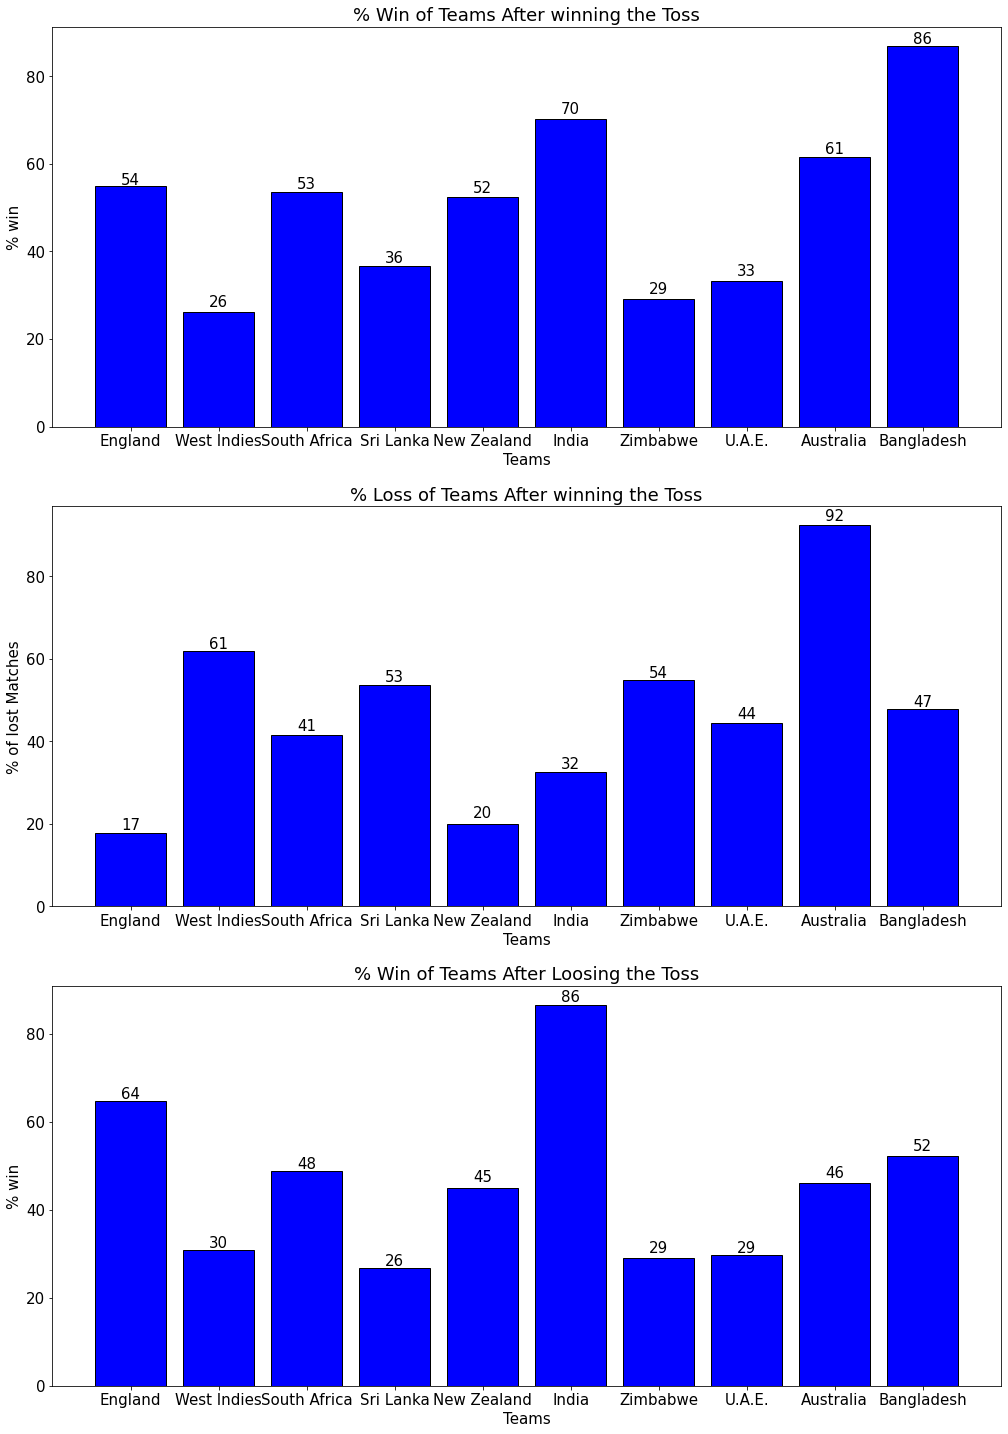

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(17,25))

#pps=[0,0,0]
pps= ax[0].bar(index, t1m1_list, color='b', edgecolor='k')
ax[0].set(xlabel='Teams', ylabel='% win', title='% Win of Teams After winning the Toss')
for p in pps:       #adding value labels on top of bars
   height = int(p.get_height())
   ax[0].annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

pps= ax[1].bar(index, t1m0_list, color='b', edgecolor='k')
ax[1].set(xlabel='Teams', ylabel='% of lost Matches', title='% Loss of Teams After winning the Toss')
for p in pps:       #adding value labels on top of bars
   height = int(p.get_height())
   ax[1].annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

pps= ax[2].bar(index, t0m1_list, color='b', edgecolor='k')
ax[2].set(xlabel='Teams', ylabel='% win', title='% Win of Teams After Loosing the Toss')

for p in pps:         #adding value labels on top of bars
   height = int(p.get_height())
   ax[2].annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.rcParams.update({'font.size': 15})
plt.show()

###**Conclusion:**

When we look at the three plots explaining the Toss and Match Results, we can come to few conclusions. 

  Firstly, the impact of Toss on winning the game is different for different Teams. There are teams which utilizes the toss to its advantage, and there are teams who can not utilize the Toss efficiently.

  The Teams like England, South Africa and Bangladesh are found to be utilizing the toss to turn the match in their favour. They have quite a higher ratio in Winning percentage after winning the toss.

  Surprisingly one of the strong ODI team, i.e Australia is showing a negative trend with respect to toss results. Their winning has very less to say about the toss. They even have a 92%  loss ratio after winning the toss, which was quite surprising. Other teams which could not utilize their toss results to win the game include West Indies, Sri Lanka and Zimbabwe.

  Coming to the performance of India, India is one such team which could utilize the toss to its favour. It has a winning rate of 70% after winning the toss. Also even if the toss is lost it still has won 86% of the games which is quite outstanding in the records! 

##**Part B: Selecting the World XI Team for the ICC T20I World Cup 2022 based on Statistics**

The next curious question we have taken is to select the team consisting of the best players of T20 International from all the countries. We have taken the Indian Premier League's ball by ball data of last 5 years and framed different questions to be answered using this data which can eventually determine the qualities of different players.

The data was readily available in the Kaggle link - https://www.kaggle.com/datasets/vora1011/ipl-2008-to-2021-all-match-dataset 

This part of the project does not focus much on scrapping the data, which we have already done for Part A. Here the major focus was on cleaning the data, preprocessing it to answer the questions that we need, visualizing it to come to a conclusion and finally selecting the team consistig of best players around the world.

 It should be noted that this cricket analysis is purely based on statistics and data, considering only a domestic league of the game. Hence the final team selection might not be the perfect one. However we consider this as an attempt on using our skills learnt in this course to make a "data driven decision"! 

In this part we have sub divided the selection into 3 categories of selection criteria.

1. **Top Order Batsmen** - Consisting of 3 players with certain qualities to play at batting positions 1,2 and 3

2. **Middle Order Batsmen**- Consisting of 3 batsmen, who can rotate strike and play against spin in the middle overs, who can also be a game finisher in the final overs.

3. **Bowlers**- At the end we need 5 bowlers, possibly 2/3 spinners and 3/2 seam bowlers, apart from the allrounders.

We framed different questions, analysed using the data to pick these players

###**Data Preprocessing**

In [ ]:
# Helper code for plotting

import matplotlib.pyplot as plt
large = 26; med = 22; small = 18
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.linewidth': 2,
          'xtick.labelsize': med,
          'xtick.color' : 'blue',
          'ytick.color' : 'blue',
          'ytick.labelsize': med,
          'axes.edgecolor':'black',
          'figure.titlesize': large}
plt.style.use('seaborn-whitegrid')
plt.rcParams.update(params)
%matplotlib inline

In [ ]:
IPL_bbb_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IPL_Ball_by_Ball_2008_2022.csv")
#IPL_matches_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IPL_Matches_2008_2022.csv")
powerplay_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/powerplay_data.csv")
#country_player_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/personal_male.csv")

In [ ]:
IPL_bbb_df.head()

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,non_boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,1,0,0,NaN,NaN,NaN,Rajasthan Royals
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals


In [ ]:
IPL_matches_df.head()

,ID,City,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,WonBy,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2
0,1312200,Ahmedabad,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
1,1312199,Ahmedabad,2022-05-27,2022,Qualifier 2,Royal Challengers Bangalore,Rajasthan Royals,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,field,N,Rajasthan Royals,Wickets,7.0,NaN,JC Buttler,"['V Kohli', 'F du Plessis', 'RM Patidar', 'GJ ...","['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...",CB Gaffaney,Nitin Menon
2,1312198,Kolkata,2022-05-25,2022,Eliminator,Royal Challengers Bangalore,Lucknow Super Giants,"Eden Gardens, Kolkata",Lucknow Super Giants,field,N,Royal Challengers Bangalore,Runs,14.0,NaN,RM Patidar,"['V Kohli', 'F du Plessis', 'RM Patidar', 'GJ ...","['Q de Kock', 'KL Rahul', 'M Vohra', 'DJ Hooda...",J Madanagopal,MA Gough
3,1312197,Kolkata,2022-05-24,2022,Qualifier 1,Rajasthan Royals,Gujarat Titans,"Eden Gardens, Kolkata",Gujarat Titans,field,N,Gujarat Titans,Wickets,7.0,NaN,DA Miller,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",BNJ Oxenford,VK Sharma
4,1304116,Mumbai,2022-05-22,2022,70,Sunrisers Hyderabad,Punjab Kings,"Wankhede Stadium, Mumbai",Sunrisers Hyderabad,bat,N,Punjab Kings,Wickets,5.0,NaN,Harpreet Brar,"['PK Garg', 'Abhishek Sharma', 'RA Tripathi', ...","['JM Bairstow', 'S Dhawan', 'M Shahrukh Khan',...",AK Chaudhary,NA Patwardhan


In [ ]:
powerplay_df.head()

,Unnamed: 0,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,non_boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam
0,0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
1,1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals
2,2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,1,0,0,NaN,NaN,NaN,Rajasthan Royals
3,3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
4,4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals


###**B.1 : Top Order Batsmen**

In the game of cricket the Openers play a very crucial role in setting foundation to the game. They are the ones who get to play in Power-Play Overs (Overs with field restrictions). Hence 'aggressive' openers are crucial in utilizing the powerplay overs and to set a high score in the game. But having all 3 players as aggressive players can also be a bad idea as the chances of them loosing wicket can also be high. Hence there is need of one "Anchor Batsman" who will stick at one end, rotate strike and allow the aggressive batsman to play the game.

So our very 1st question was-

####**"Who is a better Anchor Batsman?"**

**Players who played most number of balls**

In [ ]:
#looking into types of extras in the df
IPL_bbb_df.extra_type.value_counts()

wides      7025
legbyes    3531
noballs     908
byes        583
penalty       2
Name: extra_type, dtype: int64

In [ ]:
# to get players who played most number of balls , we have to first remove all the wides , noballs from the IPL_bbb_df
mask = (IPL_bbb_df["extra_type"]!="wides")&(IPL_bbb_df["extra_type"]!="noballs")
df = IPL_bbb_df[mask]
df.extra_type.value_counts()

legbyes    3531
byes        583
penalty       2
Name: extra_type, dtype: int64

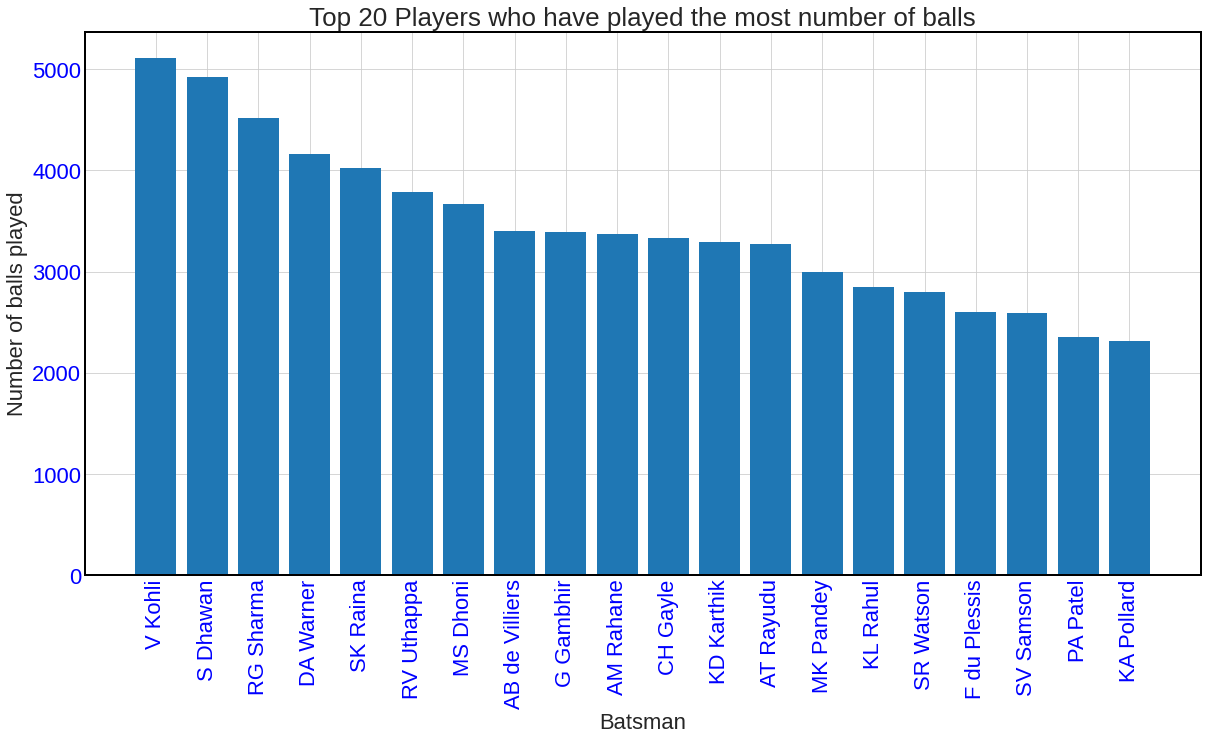

In [ ]:
balls_played = df.batter.value_counts()
plt.figure(figsize=(20,10))
plt.bar(balls_played[:20].keys(),balls_played[:20].values)
plt.title("Top 20 Players who have played the most number of balls")
plt.xlabel("Batsman")
plt.ylabel("Number of balls played")
plt.xticks(rotation=90)
plt.show()

**Player who faced max number of balls in a single match before giving away his wicket**

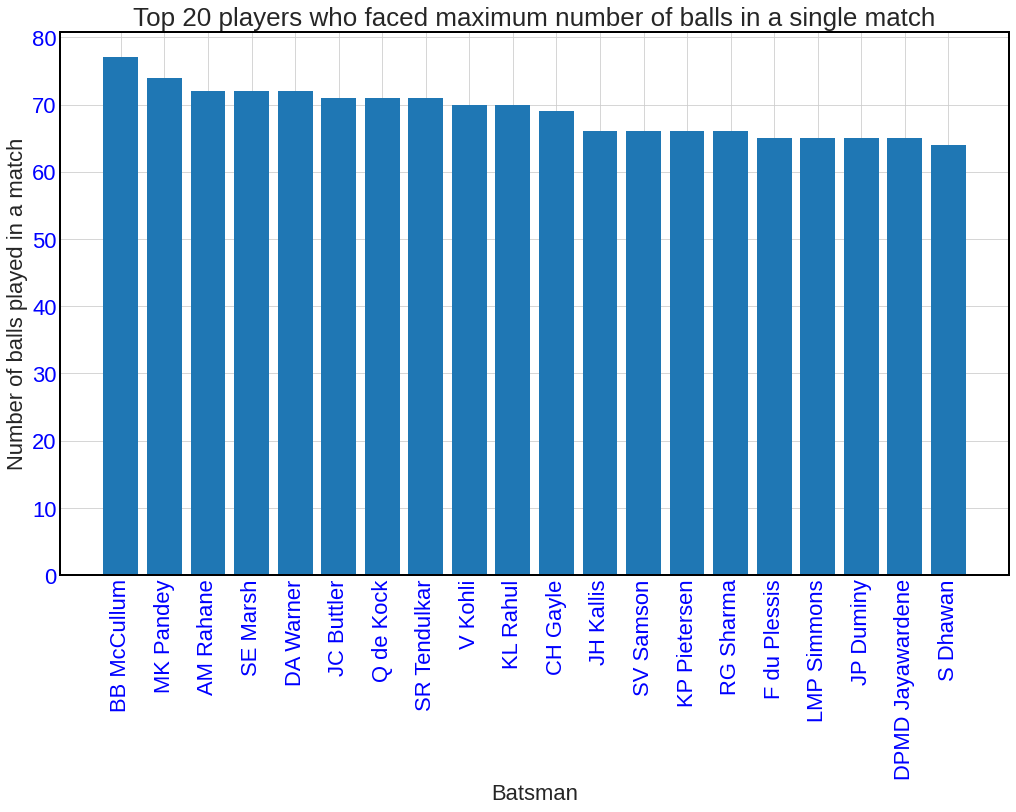

In [ ]:
#top 20 players who faced max number of balls in a single match
#taking top 32 as some players repeat
s = IPL_bbb_df.groupby("ID").batter.value_counts().reset_index(level=0,drop=True).sort_values(ascending=False)[:32]
#plotting
plt.figure(figsize=(17,10))
plt.bar(s.keys(),s.values)
plt.title("Top 20 players who faced maximum number of balls in a single match")
plt.xlabel("Batsman")
plt.ylabel("Number of balls played in a match")
plt.xticks(rotation=90)
plt.show()




**Players with the highest dot ball %**

In [ ]:
#get number of dot balls per player and balls played in one df

dot_balls = pd.DataFrame(df[df["batsman_run"]==0].batter.value_counts())
dot_balls.rename(columns={"batter":"dot_balls"},inplace=True)
dot_balls["balls_played"] = balls_played
dot_balls["dot_balls_per"] = (dot_balls["dot_balls"]/balls_played*100)
dot_balls.sort_values(by="dot_balls_per",ascending=False)

,dot_balls,balls_played,dot_balls_per
S Lamichhane,1,1,100.000000
U Kaul,1,1,100.000000
KR Sen,3,3,100.000000
RR Bhatkal,2,2,100.000000
R Sanjay Yadav,2,2,100.000000
...,...,...,...
TU Deshpande,3,12,25.000000
GB Hogg,5,22,22.727273
SJ Srivastava,1,5,20.000000
A Choudhary,4,20,20.000000


We can see that most of the players with the highest dot ball percentage also have lowest number of balls played. To get more information from this we'll remove the players who have played less number of balls

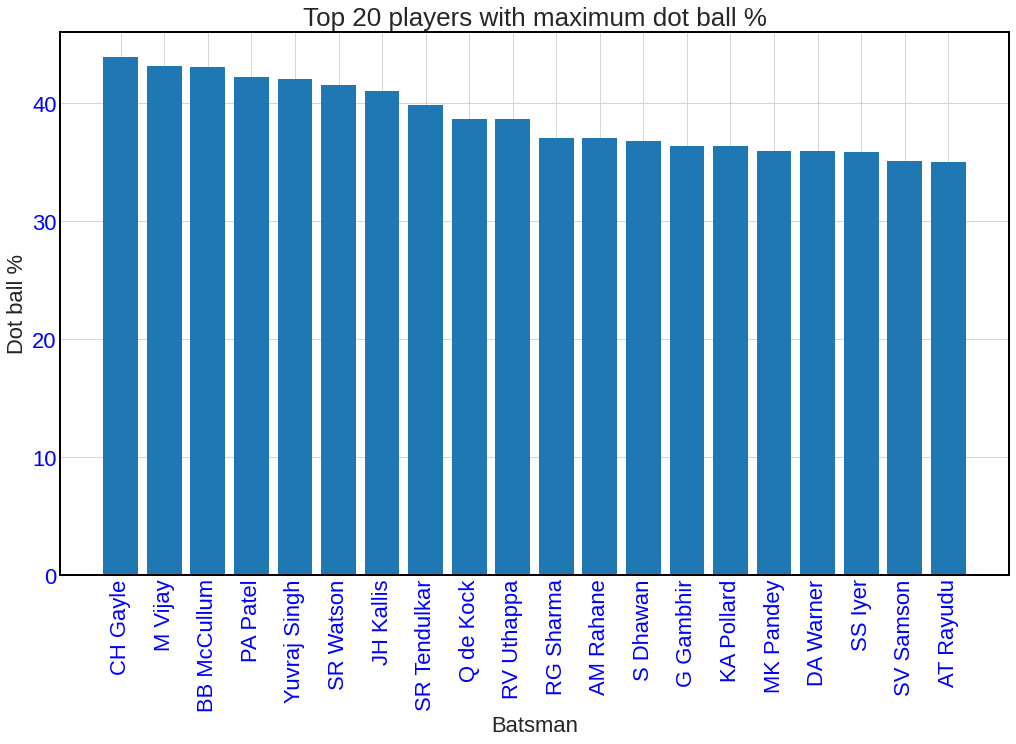

In [ ]:
#taking players above the 95 percentile of balls played
x = np.quantile(dot_balls.balls_played,0.95)
df1 = dot_balls[dot_balls["balls_played"]>x].sort_values(by="dot_balls_per",ascending=False)[:20]

#plotting
plt.figure(figsize=(17,10))
plt.bar(df1.dot_balls_per.index,df1.dot_balls_per.values)
plt.title("Top 20 players with maximum dot ball %")
plt.xlabel("Batsman")
plt.ylabel("Dot ball %")
plt.xticks(rotation=90)
plt.show()


We can also check the dot ball % of the top 20 players with maximum balls played

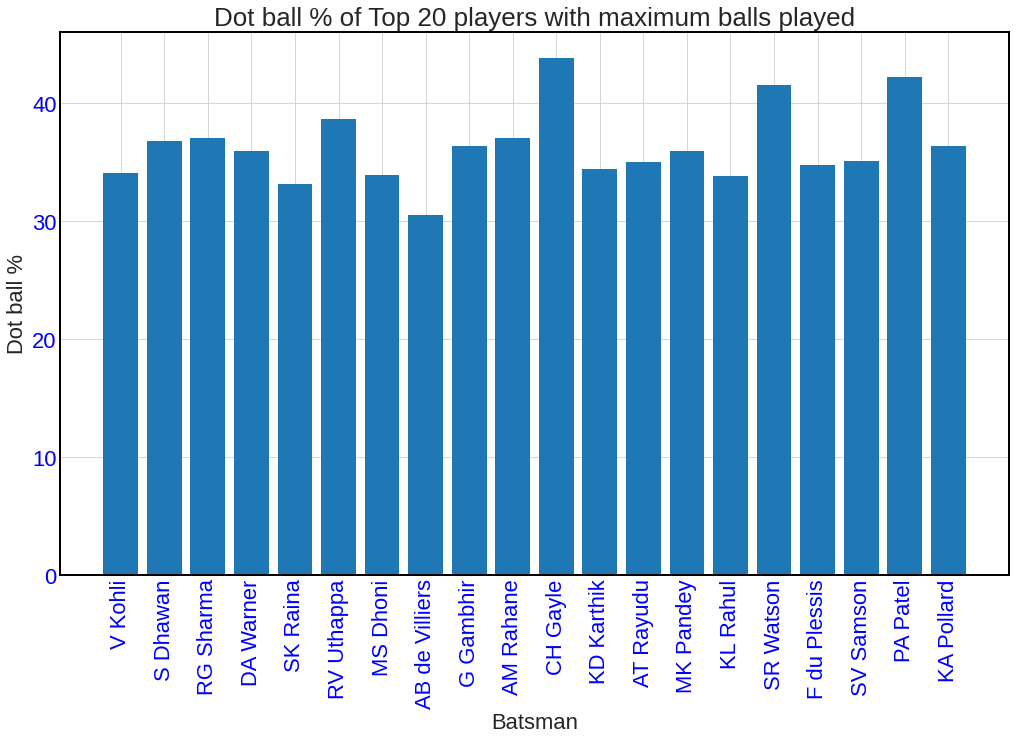

In [ ]:
#getting the dot ball % of the top 20 players with maximum balls played
s1 = dot_balls.loc[balls_played[:20].keys()]["dot_balls_per"]

#plotting
plt.figure(figsize=(17,10))
plt.bar(s1.keys(),s1.values)
plt.title("Dot ball % of Top 20 players with maximum balls played")
plt.xlabel("Batsman")
plt.ylabel("Dot ball %")
plt.xticks(rotation=90)
plt.show()


From visually analysing the data from above plots, the best anchor batsman that we can conclude for our team is "V Kohli" who indeed is the greatest of all times! The dot ball % graph also validates Kohli's selection into the team. 

####**Players with the highest strike rate in powerplay**

After selecting one Anchor batsman, we need two Aggressive players in the 1st 3 positions who can use powerplay to their benifit. To pick them we take Strike rate in the powerplay as the criteria. 

Lets check what the data has to say!

In [ ]:
#looking into the powerplay df
powerplay_df.head()

,Unnamed: 0,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,non_boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam
0,0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
1,1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals
2,2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,1,0,0,NaN,NaN,NaN,Rajasthan Royals
3,3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
4,4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals


In [ ]:
#runs in powerplay
runs_pp = powerplay_df.groupby("batter")["batsman_run"].sum()
runs_pp

batter
A Ashish Reddy      5
A Badoni            1
A Chopra           27
A Flintoff         14
A Manohar          12
                 ... 
YV Takawale       121
Yashpal Singh      17
Younis Khan         3
Yuvraj Singh      193
Z Khan              0
Name: batsman_run, Length: 326, dtype: int64

In [ ]:
#getting balls played in powerplay 
mask = (powerplay_df["extra_type"]!="wides")
df2 = powerplay_df[mask]
balls_played_pp = df2.batter.value_counts()
balls_played_pp

S Dhawan          2586
DA Warner         2111
G Gambhir         1868
V Kohli           1829
AM Rahane         1783
                  ... 
JL Denly             1
PJ Cummins           1
RV Gomez             1
BJ Rohrer            1
MJ McClenaghan       1
Name: batter, Length: 326, dtype: int64

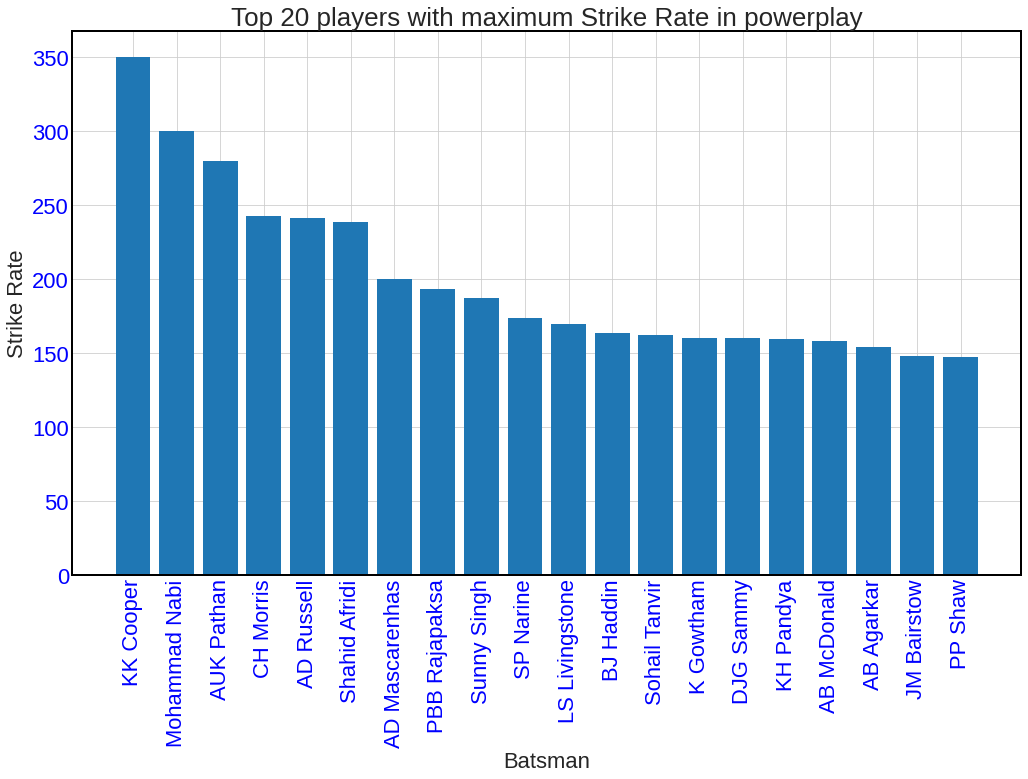

In [ ]:
#top 20 strike rate in powerplay
strike_rate = (runs_pp/balls_played_pp*100).sort_values(ascending=False)[:20]
#plotting
plt.figure(figsize=(17,10))
plt.bar(strike_rate.keys(),strike_rate.values)
plt.title("Top 20 players with maximum Strike Rate in powerplay")
plt.xlabel("Batsman")
plt.ylabel("Strike Rate")
plt.xticks(rotation=90)
plt.show()



The players who have played less number of balls will be represented more while calculating strike rate. To prevent this removing players who have played less number of balls

In [ ]:
#getting the 90 percentile in balls played
x = np.quantile(balls_played_pp,0.90)
mask1 = balls_played_pp>x

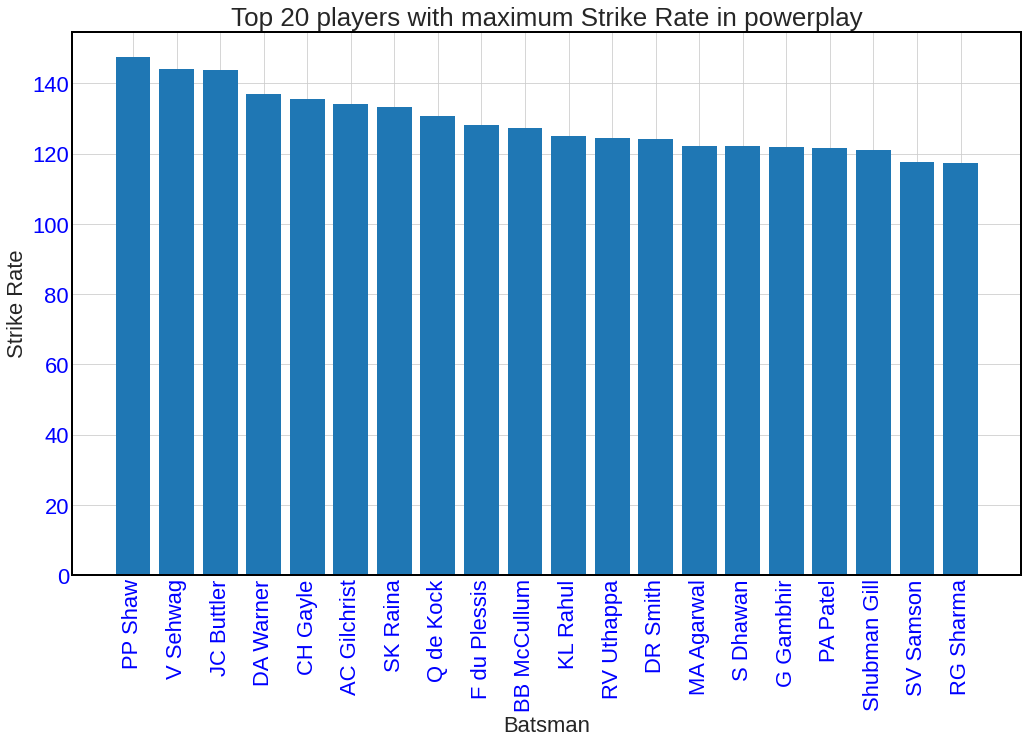

In [ ]:
#top 20 strike rate in powerplay
strike_rate_pp = (runs_pp[mask1]/balls_played_pp[mask1]*100).sort_values(ascending=False)[:20]
#plotting
plt.figure(figsize=(17,10))
plt.bar(strike_rate_pp.keys(),strike_rate_pp.values)
plt.title("Top 20 players with maximum Strike Rate in powerplay")
plt.xlabel("Batsman")
plt.ylabel("Strike Rate")
plt.xticks(rotation=90)
plt.show()



We can also check the strike rate of the top 20 players who played the most number of balls

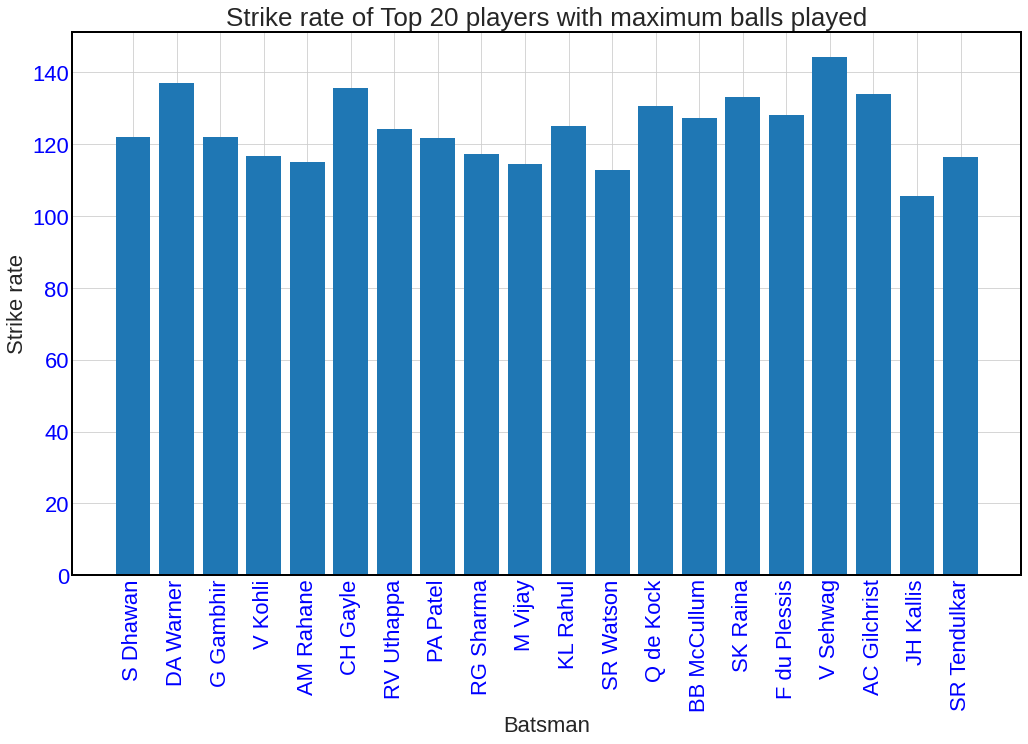

In [ ]:
# calculating strike rate for the top 20 players who played most number of balls
strike_rate2 = ((runs_pp[mask1]/balls_played_pp[mask1]*100).sort_values(ascending=False))[balls_played_pp[:20].keys()]

# plotting results
plt.figure(figsize=(17,10))
plt.bar(strike_rate2.keys(),strike_rate2.values)
plt.title("Strike rate of Top 20 players with maximum balls played")
plt.xlabel("Batsman")
plt.ylabel("Strike rate")
plt.xticks(rotation=90)
plt.show()

Considering the above graphs, and getting to know the current players, The two strikers can be:
1. DA Warner
2. S Dhawan/ JC Buttler

###Top order Team selection:
1. **DA Warner**
2. **JC Buttler**
3. **V Kohli**


###**B.2 : Middle Order Batsman**

Having selected 3 top orders batsmen for an aggressive start, we now need 3 more batsmen at 4, 5 and 6 positions. The Batsman at 4 and 5 are the backbone of a team who has to be very adaptive to the particular game, which means, the batsman at 4 and 5 has to anchor down and play deep in case there is a collapse in the top order. They also need to turn aggressive in case there was a better start. It is always the middle order that changes the pace of the game. 

The middle overs use to be of spin bowling, so these batsmen should be able to play well against the spin. Also they should be able to strike the ball in the death overs and score maximum runs in that overs. They also need to play under pressure at times. So our next analysis is to select such players based on statistics.

Here we have two dataframes one is the data containing the ball by ball data i.e. the runs scored per ball or wickets taken etc. which is assigned to the variable full_balldf.

The second dataframes contains the match information i.e. match result, team members, result etc. whic his assigned to the variable full_matchdf


####**Preprocessing**

In [ ]:
#Bowl by Bowl Dataframe
full_balldf = pd.read_csv("IPL_Ball_by_Ball_2008_2022.csv")
#Match by Match Dataframe
full_matchdf = pd.read_csv("IPL_Matches_2008_2022.csv")
print(full_balldf.columns)
print(full_matchdf.columns)

Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam'],
      dtype='object')
Index(['ID', 'City', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2',
       'Venue', 'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam',
       'WonBy', 'Margin', 'method', 'Player_of_Match', 'Team1Players',
       'Team2Players', 'Umpire1', 'Umpire2'],
      dtype='object')


We are taking into account the matches played in the last 5 years i.e. from 2018 - 2022. We are creating a dataframes of each years match information and a combined one.

In [ ]:
#Creating a new "Year" column
full_matchdf["Year"] = full_matchdf['Date'].apply(lambda x:int(x[:4]))

#Extracting the last 5 years from the matches dataframe along with individual years
full_matchdf = full_matchdf[full_matchdf["Year"]>=2018]
match_2018df = full_matchdf[full_matchdf["Year"]==2018]
match_2019df = full_matchdf[full_matchdf["Year"]==2019]
match_2020df = full_matchdf[full_matchdf["Year"]==2020]
match_2021df = full_matchdf[full_matchdf["Year"]==2021]
match_2022df = full_matchdf[full_matchdf["Year"]==2022]

#Years extracted
full_matchdf["Year"].unique()

array([2022, 2021, 2020, 2019, 2018])

In [ ]:
match_2022df.shape

(74, 21)

We created a function to create seperate dataframes based on the years of the data and we also created a 5 year dataframe containing all the information to evaluate players on the basis of their performance in the past 5 years.

In [ ]:
#Function to extract the dataframe which contains the balls bowled for that year
def ball_ball_df(df):
    valid_ids = df["ID"].to_list()
    new_df = full_balldf.copy()
    #IDs present in the ball to ball dataframe
    all_ids = list(new_df["ID"].unique())
    for id in tqdm(all_ids):
        if id in valid_ids:
            continue
        else:
            new_df = new_df[new_df["ID"]!=id]
    return new_df

In [ ]:
#Extracting the last 5 years from the ball-ball dataframe along with individual years
full_balldf = ball_ball_df(full_matchdf)
ball_2018df = ball_ball_df(match_2018df)
ball_2019df = ball_ball_df(match_2019df)
ball_2020df = ball_ball_df(match_2020df)
ball_2021df = ball_ball_df(match_2021df)
ball_2022df = ball_ball_df(match_2022df)

100%|██████████| 314/314 [00:01<00:00, 216.80it/s]


In [ ]:
print(f"The amount of matches played between 2018-2022 in the Balls dataframe: {len(full_balldf['ID'].unique())}")
print(f"The amount of matches played between 2018 in the Balls dataframe: {len(ball_2018df['ID'].unique())}")
print(f"The amount of matches played between 2019 in the Balls dataframe: {len(ball_2019df['ID'].unique())}")
print(f"The amount of matches played between 2020 in the Balls dataframe: {len(ball_2020df['ID'].unique())}")
print(f"The amount of matches played between 2021 in the Balls dataframe: {len(ball_2021df['ID'].unique())}")
print(f"The amount of matches played between 2022 in the Balls dataframe: {len(ball_2022df['ID'].unique())}")

The amount of matches played between 2018-2022 in the Balls dataframe: 314
The amount of matches played between 2018 in the Balls dataframe: 60
The amount of matches played between 2019 in the Balls dataframe: 60
The amount of matches played between 2020 in the Balls dataframe: 60
The amount of matches played between 2021 in the Balls dataframe: 60
The amount of matches played between 2022 in the Balls dataframe: 74


In [ ]:
#Runs scored Function
def runs_scored(df):
    runs_scored = {}
    #List of all the batters from 2018-2022 who have batted 
    batters = list(df.batter.unique())
    #Going through all the batters
    for batter in tqdm(batters):
        #Creating the dataframe only for that batter
        bat_df = df.loc[df["batter"]==batter]
        #Finding the outcome of all the balls that he has batted
        runs = bat_df.batsman_run.unique
        count = 0
        for runs in bat_df.batsman_run:
          count+= runs
        runs_scored[batter] = count
    return runs_scored

#Top 30 Batter runs Extracter Function
def top_30_run(runs_scored):
    sorted_runs_scored = {k: v for k, v in sorted(runs_scored.items(), key=lambda item: item[1],reverse=True)}
    top_30_run = dict(list(sorted_runs_scored.items())[0:30])
    return top_30_run

#Top 30 Batter average Extracter Function
def top_30_avg(runs_scored):
    sorted_average = {k: v for k, v in sorted(runs_scored.items(), key=lambda item: item[1],reverse=True)}
    top_30_average = dict(list(sorted_average.items())[0:30])
    return top_30_average

#Top 30 Bowler Strike-Rate Extracter Function
def top_30_sr(runs_scored):
    sorted_sr = {k: v for k, v in sorted(runs_scored.items(), key=lambda item: item[1], reverse = True)}
    top_30_sr = dict(list(sorted_sr.items())[0:30])
    return top_30_sr

####**Highest Run getter in between the years 2018 and 2022**

In [ ]:
run_18_22 = runs_scored(full_balldf)
#Extracting the Top 30 Batters according to the number of wickets taken
top_30_runs = top_30_run(run_18_22)

100%|██████████| 286/286 [00:01<00:00, 154.22it/s]


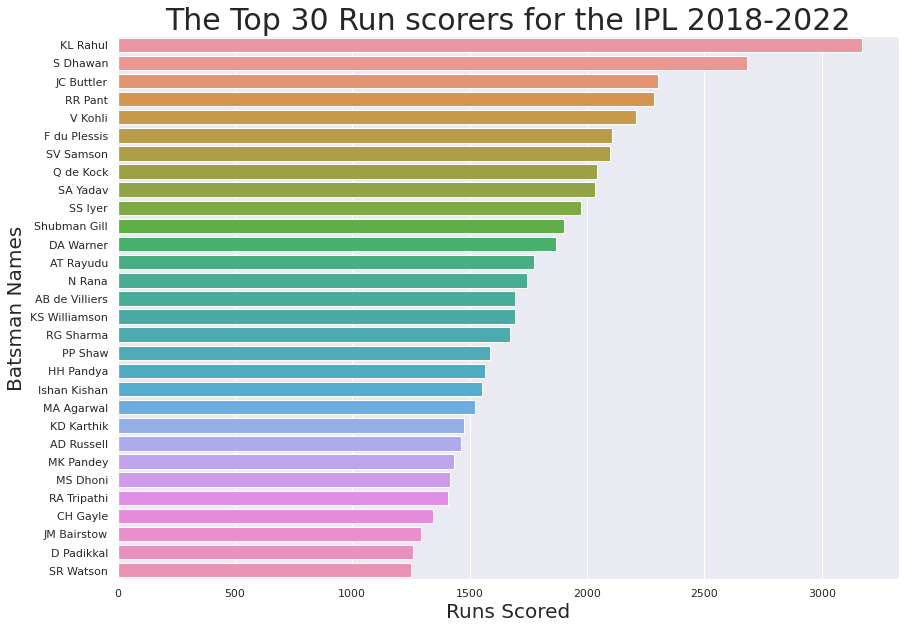

In [ ]:
keys = top_30_runs.keys()
values = top_30_runs.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 Run scorers for the IPL 2018-2022",fontsize=30)
plt.xlabel('Runs Scored',fontsize=20)
plt.ylabel('Batsman Names', fontsize=20)
plt.show()

**Top run scorers of the last 5 seasons -**

In [ ]:
run_18 = runs_scored(ball_2018df)
#Extracting the Top 30 Batters according to the number of Runs scored
top_30_run_18 = top_30_run(run_18)
run_19 = runs_scored(ball_2019df)
#Extracting the Top 30 Batters according to the number of Runs scored
top_30_run_19 = top_30_run(run_19)
run_20 = runs_scored(ball_2020df)
#Extracting the Top 30 Batters according to the number of Runs scored
top_30_run_20 = top_30_run(run_20)
run_21 = runs_scored(ball_2021df)
#Extracting the Top 30 Batters according to the number of Runs scored
top_30_run_21 = top_30_run(run_21)
run_22 = runs_scored(ball_2022df)
#Extracting the Top 30 Batters according to the number of Runs scored
top_30_run_22 = top_30_run(run_22)

100%|██████████| 174/174 [00:00<00:00, 543.67it/s]


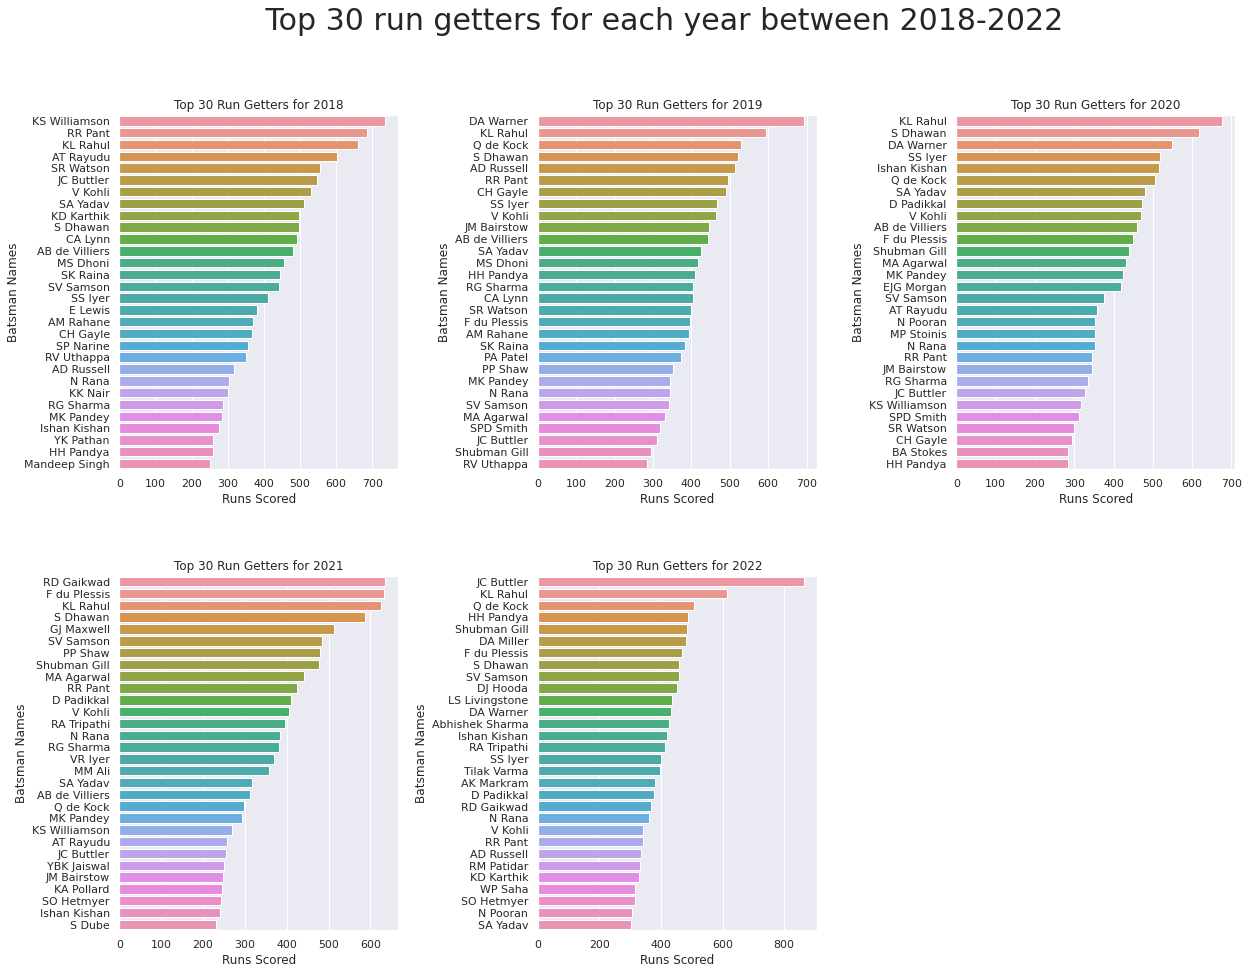

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.300, wspace=0.500)
fig.suptitle(' Top 30 run getters for each year between 2018-2022', fontsize=30)


keys_18 = top_30_run_18.keys()
values_18 = top_30_run_18.values()
keys_19 = top_30_run_19.keys()
values_19 = top_30_run_19.values()
keys_20 = top_30_run_20.keys()
values_20 = top_30_run_20.values()
keys_21 = top_30_run_21.keys()
values_21 = top_30_run_21.values()
keys_22 = top_30_run_22.keys()
values_22 = top_30_run_22.values()

columns = 3
rows = 2
fig.add_subplot(rows, columns, 1)
ax1 = sns.barplot(y=list(keys_18), x=list(values_18))
ax1.set(xlabel="Runs Scored", ylabel="Batsman Names", title="Top 30 Run Getters for 2018")
fig.add_subplot(rows, columns, 2)
ax2= sns.barplot(y=list(keys_19), x=list(values_19))
ax2.set(xlabel="Runs Scored", ylabel="Batsman Names", title="Top 30 Run Getters for 2019")
fig.add_subplot(rows, columns, 3)
ax3 = sns.barplot(y=list(keys_20), x=list(values_20))
ax3.set(xlabel="Runs Scored", ylabel="Batsman Names", title="Top 30 Run Getters for 2020")
fig.add_subplot(rows, columns, 4)
ax4 = sns.barplot(y=list(keys_21), x=list(values_21))
ax4.set(xlabel="Runs Scored", ylabel="Batsman Names", title="Top 30 Run Getters for 2021")
fig.add_subplot(rows, columns, 5)
ax5 = sns.barplot(y=list(keys_22), x=list(values_22))
ax5.set(xlabel="Runs Scored", ylabel="Batsman Names", title="Top 30 Run Getters for 2022")
    
plt.show()


Top run scorer for Season 2018 - DA Warner, KL Rahul, Q de Kock


Top run scorer for Season 2019 - KS Williamson, RR Pant, KL Rahul

Top run scorer for Season 2020 - KL Rahul, S Dhawan, DA Warner

Top run scorer for Season 2021 - RD Gaikwad, F du Plessis, KL Rahul

Top run scorer for Season 2022 - JC buttler, KL Rahul, Q de Kock

One Name is common in all the seasons i.e. - KL Rahul and he has been the most consistent player of the IPL which was evident in the previous graph too

So according to above results the best batsman are the above players in the graph , but is it so ?? There may be some players who have played more matches than the other batsman for eg. the batsman of the teams who qualified for the semifinal and final will have more matches and will therefore score more runs. Therefore, to more generalize the results we introduce the concept of average .

**What is Average ??**

Average is the ratio of numbers of runs scored and number of times wicket lost, it gives us a better picture of who the best players are, but there must be some players who have played a couple of matches and have returned not out so to remove such players we are taking into account only those players who have scored more than 100 runs in a season or 500 runs from 2018-2022 season

####**Batsman with the highest average between years 2018 - 2022**

In [ ]:
#Batting Average Calculator Function for all 5 years
def bat_avg_calc_total(df):
    bat_avg = {}
    #List of all the batters from 2018-2022 who have bowled
    batters = list(df.batter.unique())
    for batter in tqdm(batters):
        bat_df = df.loc[df["batter"]==batter]
        run = full_balldf[full_balldf['batter'] == batter]
        runs = run.batsman_run.sum()
        if runs > 500:
          wickets = run[run['player_out'] == batter].shape[0]
          avg = round(runs/wickets,4)
          bat_avg[batter] = avg
    return bat_avg

In [ ]:
#Batting Average Calculator Function for individual 5 years
def bat_avg_calc(df):
    bat_avg = {}
    #List of all the batters from 2018-2022 who have bowled
    batters = list(df.batter.unique())
    for batter in tqdm(batters):
        run = full_balldf[full_balldf['batter'] == batter]
        runs = run.batsman_run.sum()
        if runs > 100:
          wickets = run[run['player_out'] == batter].shape[0]
          avg = round(runs/wickets,4)
          bat_avg[batter] = avg
    return bat_avg

In [ ]:
average_all = bat_avg_calc_total(full_balldf)
top_30_average = top_30_avg(average_all)

100%|██████████| 286/286 [00:03<00:00, 77.77it/s]


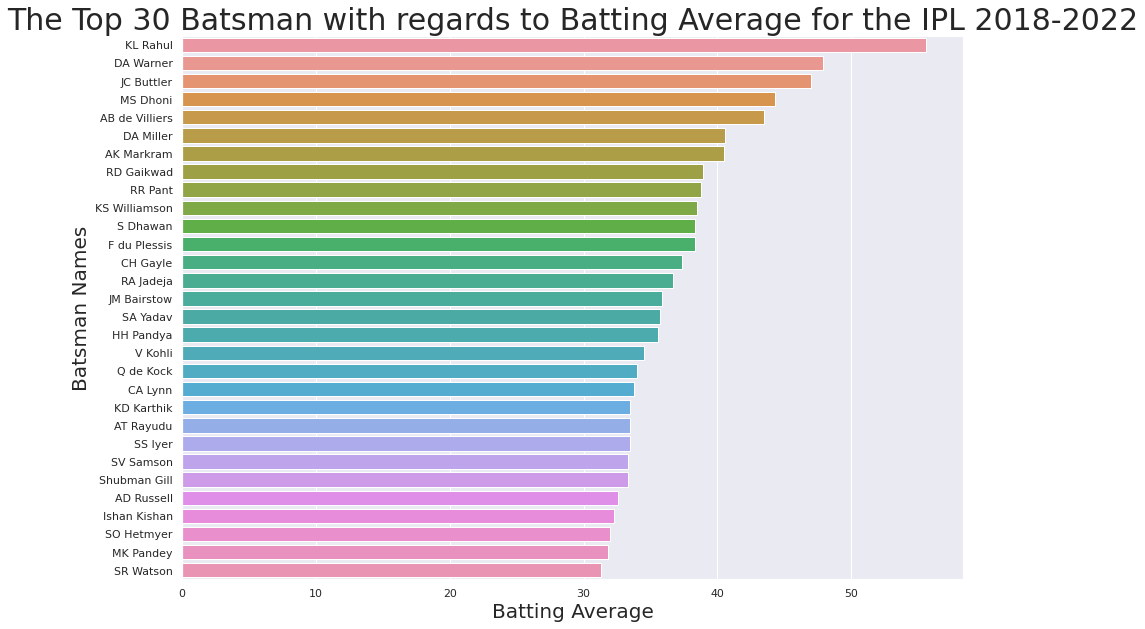

In [ ]:
keys = top_30_average.keys()
values = top_30_average.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 Batsman with regards to Batting Average for the IPL 2018-2022",fontsize=30)
plt.xlabel('Batting Average',fontsize=20)
plt.ylabel('Batsman Names', fontsize=20)
plt.show()

####**Batsman with most batting average for last 5 seasons- Consistency check:**

In [ ]:
avg_18 = bat_avg_calc(ball_2018df)
#Extracting the Top 30 Batters according to the economy taken
top_30_avg_18 = top_30_avg(avg_18)
avg_19 = bat_avg_calc(ball_2019df)
#Extracting the Top 30 Batters according to the economy taken
top_30_avg_19 = top_30_avg(avg_19)
avg_20 = bat_avg_calc(ball_2020df)
#Extracting the Top 30 Batters according to the economy taken
top_30_avg_20 = top_30_avg(avg_20)
avg_21 = bat_avg_calc(ball_2021df)
#Extracting the Top 30 Batters according to the economy taken
top_30_avg_21 = top_30_avg(avg_21)
avg_22 = bat_avg_calc(ball_2022df)
#Extracting the Top 30 Batters according to the economy taken
top_30_avg_22 = top_30_avg(avg_22)

100%|██████████| 174/174 [00:01<00:00, 146.37it/s]


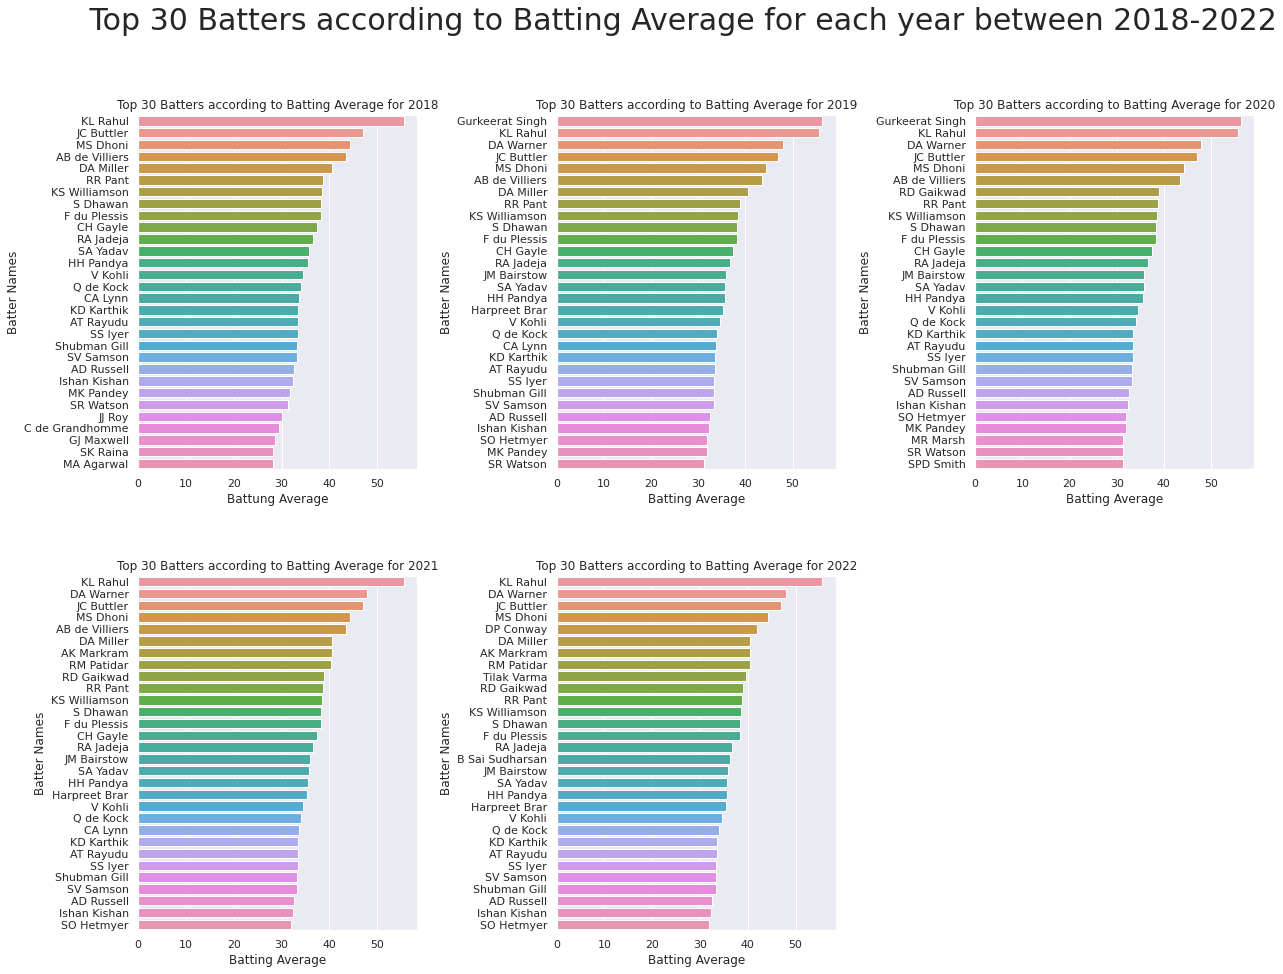

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.300, wspace=0.500)
fig.suptitle(' Top 30 Batters according to Batting Average for each year between 2018-2022', fontsize=30)


keys_18 = top_30_avg_18.keys()
values_18 = top_30_avg_18.values()
keys_19 = top_30_avg_19.keys()
values_19 = top_30_avg_19.values()
keys_20 = top_30_avg_20.keys()
values_20 = top_30_avg_20.values()
keys_21 = top_30_avg_21.keys()
values_21 = top_30_avg_21.values()
keys_22 = top_30_avg_22.keys()
values_22 = top_30_avg_22.values()

columns = 3
rows = 2
fig.add_subplot(rows, columns, 1)
ax1 = sns.barplot(y=list(keys_18), x=list(values_18))
ax1.set(xlabel="Batting Average", ylabel="Batter Names", title="Top 30 Batters according to Batting Average for 2018")
fig.add_subplot(rows, columns, 2)
ax2= sns.barplot(y=list(keys_19), x=list(values_19))
ax2.set(xlabel="Batting Average", ylabel="Batter Names",title="Top 30 Batters according to Batting Average for 2019")
fig.add_subplot(rows, columns, 3)
ax3 = sns.barplot(y=list(keys_20), x=list(values_20))
ax3.set(xlabel="Batting Average", ylabel="Batter Names",title="Top 30 Batters according to Batting Average for 2020")
fig.add_subplot(rows, columns, 4)
ax4 = sns.barplot(y=list(keys_21), x=list(values_21))
ax4.set(xlabel="Batting Average", ylabel="Batter Names",title="Top 30 Batters according to Batting Average for 2021")
fig.add_subplot(rows, columns, 5)
ax5 = sns.barplot(y=list(keys_22), x=list(values_22))
ax5.set(xlabel="Batting Average", ylabel="Batter Names",title="Top 30 Batters according to Batting Average for 2022")
    
plt.show()

Batsman with best average for Season 2018 - KL Rahul, JC Buttler, MS Dhoni

Batsman with best average for Season 2019 - Gurkeerat Singh, KL Rahul, DA Warner

Batsman with best average for Season 2020 - Gurkeerat Singh, KL Rahul, DA Warner

Batsman with best average for Season 2021 - KL Rahul, DA Warner, JC Buttler

Batsman with best average for Season 2022 - KL Rahul, DA Warner, JC Buttler

By considering the above analysis, **KL Rahul** become the obvious selection to our team at No. 4!

So above is the graph representing the batsman with the highest average in all the years individually and also the combined graph. But is average the solution to our problem.. Let's take a hypothetical problem in a T20 matches the average winning score is 160 plus. We assume that a batsman has a very good average and he plays 100 balls out of the 120 balls in a T20 match and he scores 140 runs so will it be called a great innings with respect to the T20 format. The answer will be NO. Why?? Because he might have played a great innings but the team was not able to reach a good score. So where is the problem ??. To answer this question to introduce a new aspect of batting which is called Strike Rate.

**What is Strike Rate ??**

Strike Rate can be calculated as (runs scored/balls faced) *100

It is the average runs scored by the batsman after facing 100 balls, it shows the impact the batsman's innings had on the team's score. But we face a problem in it too that there may be some players who might have faced only a couple of deliveries in the whole tournament but scored a boundry on that ball which will increase their strike rate exponentially. So to solve this problem we have introduced a condition that the batsman who have faced 20 deliveries in a season and 100 deliveries in the time period of 2018-2022 will only be considered 

####**Batsmen Strike rate in last 5 seasons**

In [ ]:
#Batting Average Calculator Function for all 5 years
def bat_sr_calc_total(df):
    bat_str = {}
    #List of all the batters from 2018-2022 who have batted
    batters = list(df.batter.unique())
    for batter in tqdm(batters):
        bat_df = df.loc[df["batter"]==batter]
        run = full_balldf[full_balldf['batter'] == batter]
        runs = run.batsman_run.sum()
        balls = len(run.batsman_run)
        if balls > 100:
          strike_rate = round((runs/balls)*100,4)
          bat_str[batter] = strike_rate
    return bat_str

In [ ]:
#Batting Average Calculator Function for all 5 years
def bat_sr_calc(df):
    bat_str = {}
    #List of all the batters from 2018-2022 who have batted
    batters = list(df.batter.unique())
    for batter in tqdm(batters):
        bat_df = df.loc[df["batter"]==batter]
        run = full_balldf[full_balldf['batter'] == batter]
        runs = run.batsman_run.sum()
        balls = len(run.batsman_run)
        if balls > 20:
          strike_rate = round((runs/balls)*100,4)
          bat_str[batter] = strike_rate
    return bat_str

In [ ]:
sr_all = bat_sr_calc_total(full_balldf)
top_30_strikerate = top_30_sr(sr_all)

100%|██████████| 286/286 [00:03<00:00, 78.91it/s]


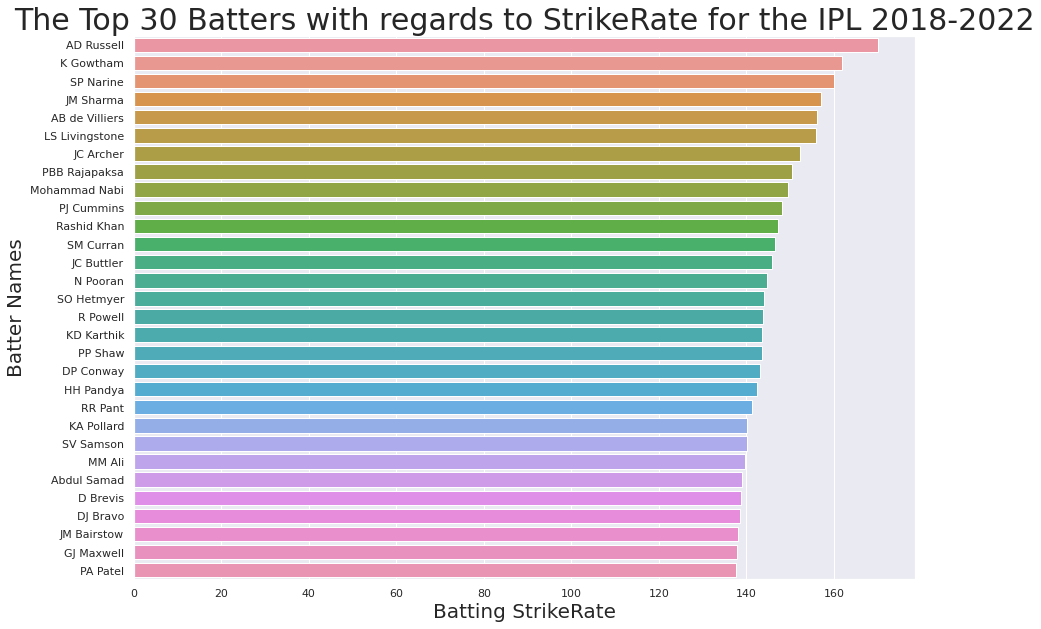

In [ ]:
keys = top_30_strikerate.keys()
values = top_30_strikerate.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 Batters with regards to StrikeRate for the IPL 2018-2022",fontsize=30)
plt.xlabel('Batting StrikeRate',fontsize=20)
plt.ylabel('Batter Names', fontsize=20)
plt.show()

Batsman with high Strike Rates are generally finishers or Lower Middle Over Batsman whose work is to increase the Run-Rate or the average runs scored per over to post a challenging total in the end. 

####**Batsman with highest Strike rates in the period of 2018-2022** 

In [ ]:
sr_18 = bat_sr_calc(ball_2018df)
#Extracting the Top 30 Batters according to the strike rate
top_30_sr_18 = top_30_sr(sr_18)
sr_19 = bat_sr_calc(ball_2019df)
#Extracting the Top 30 Batters according to the strike rate
top_30_sr_19 = top_30_sr(sr_19)
sr_20 = bat_sr_calc(ball_2020df)
#Extracting the Top 30 Batters according to the strike rate
top_30_sr_20 = top_30_sr(sr_20)
sr_21 = bat_sr_calc(ball_2021df)
#Extracting the Top 30 Batters according to the strike rate
top_30_sr_21 = top_30_sr(sr_21)
sr_22 = bat_sr_calc(ball_2022df)
#Extracting the Top 30 Batters according to the strike rate
top_30_sr_22 = top_30_sr(sr_22)

100%|██████████| 174/174 [00:01<00:00, 121.83it/s]


Batsman with best strike rates for Season 2018 - AD Russell, K Gowtham, SP Narine

Batsman with best strike rates for Season 2019 - AD Russell, K Gowtham, SP Narine

Batsman with best strike rates for Season 2020 - AD Russell, K Gowtham, SP Narine

Batsman with best strike rates for Season 2021 - TH David, AD Russell, SP Narine

Batsman with best strike rates for Season 2022 - TH David, AD Russell, K Gowtham

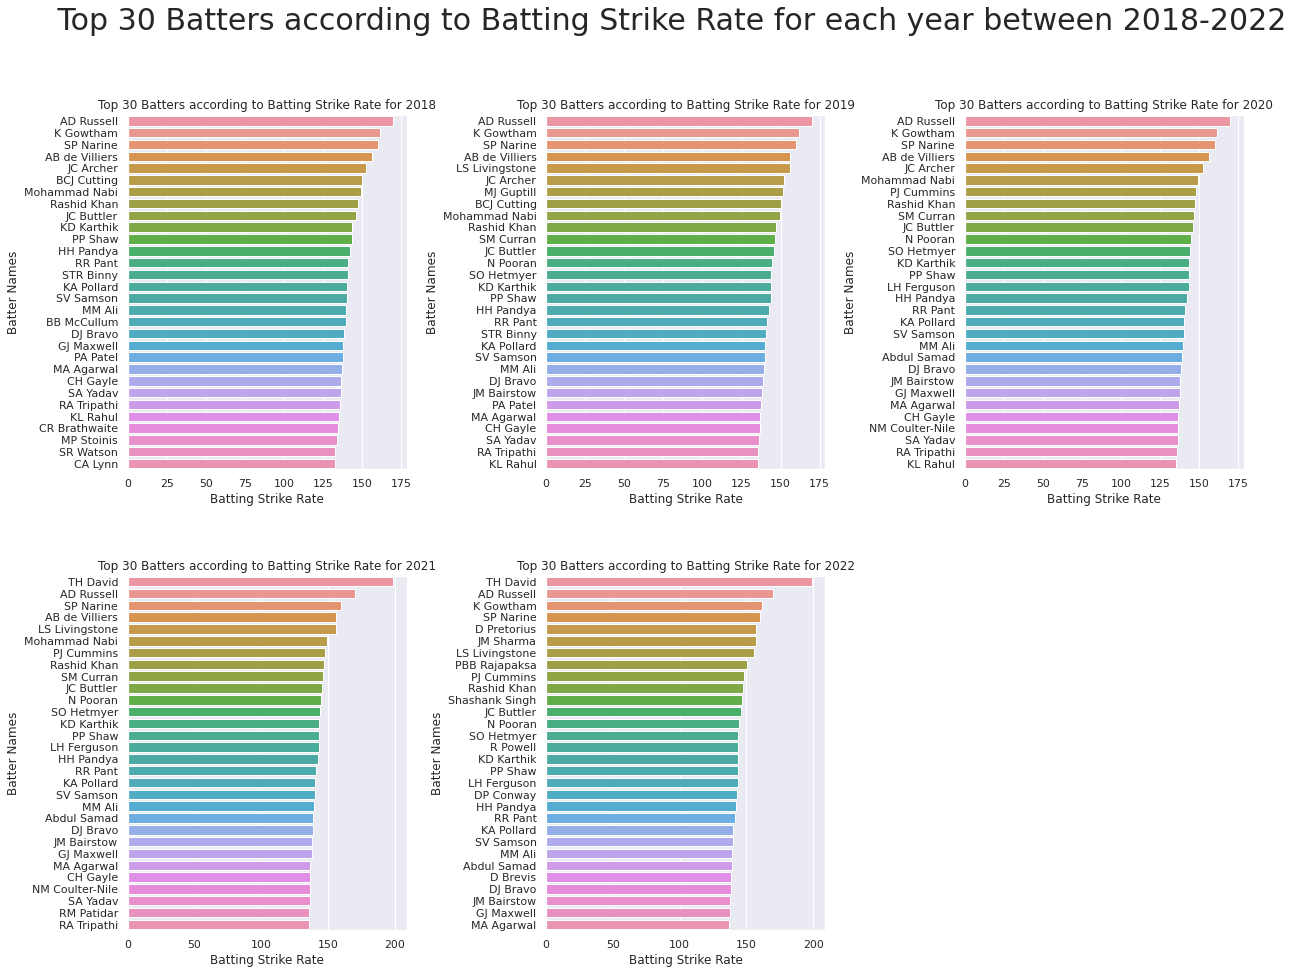

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.300, wspace=0.500)
fig.suptitle(' Top 30 Batters according to Batting Strike Rate for each year between 2018-2022', fontsize=30)


keys_18 = top_30_sr_18.keys()
values_18 = top_30_sr_18.values()
keys_19 = top_30_sr_19.keys()
values_19 = top_30_sr_19.values()
keys_20 = top_30_sr_20.keys()
values_20 = top_30_sr_20.values()
keys_21 = top_30_sr_21.keys()
values_21 = top_30_sr_21.values()
keys_22 = top_30_sr_22.keys()
values_22 = top_30_sr_22.values()

columns = 3
rows = 2
fig.add_subplot(rows, columns, 1)
ax1 = sns.barplot(y=list(keys_18), x=list(values_18))
ax1.set(xlabel="Batting Strike Rate", ylabel="Batter Names", title="Top 30 Batters according to Batting Strike Rate for 2018")
fig.add_subplot(rows, columns, 2)
ax2= sns.barplot(y=list(keys_19), x=list(values_19))
ax2.set(xlabel="Batting Strike Rate", ylabel="Batter Names",title="Top 30 Batters according to Batting Strike Rate for 2019")
fig.add_subplot(rows, columns, 3)
ax3 = sns.barplot(y=list(keys_20), x=list(values_20))
ax3.set(xlabel="Batting Strike Rate", ylabel="Batter Names",title="Top 30 Batters according to Batting Strike Rate for 2020")
fig.add_subplot(rows, columns, 4)
ax4 = sns.barplot(y=list(keys_21), x=list(values_21))
ax4.set(xlabel="Batting Strike Rate", ylabel="Batter Names",title="Top 30 Batters according to Batting Strike Rate for 2021")
fig.add_subplot(rows, columns, 5)
ax5 = sns.barplot(y=list(keys_22), x=list(values_22))
ax5.set(xlabel="Batting Strike Rate", ylabel="Batter Names",title="Top 30 Batters according to Batting Strike Rate for 2022")
    
plt.show()

By looking at the strike rate and batting average the players we are selecting is **AD Russel **and **Sunil Narine**. Their All-rounder quality will add advantage to our team.

###Middle Order Team Selection-

4. **KL Rahul**

5. **AD Russel**

6. **SP Narine**



###**B.3 Bowlers and Tail Enders**

Having selected the Batsmen till number 6, we now need 5 bowlers.

We will again raise different questions to pick bowlers with diverse qualities.

Lets Go!

####**Preprocessing-**

In [ ]:
#Creating 6 different Dataframes, 5 being the different years and the 1 being the combined 5 years
#Bowl by Bowl Dataframe
full_balldf = pd.read_csv("/content/drive/MyDrive/DS1_project_df/IPL_Ball_by_Ball_2008_2022.csv")
#Match by Match Dataframe
full_matchdf = pd.read_csv("/content/drive/MyDrive/DS1_project_df/IPL_Matches_2008_2022.csv")
print(full_balldf.columns)
print(full_matchdf.columns)

Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam'],
      dtype='object')
Index(['ID', 'City', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2',
       'Venue', 'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam',
       'WonBy', 'Margin', 'method', 'Player_of_Match', 'Team1Players',
       'Team2Players', 'Umpire1', 'Umpire2'],
      dtype='object')


Matches Dataframe

In [ ]:
#Creating a new "Year" column
full_matchdf["Year"] = full_matchdf['Date'].apply(lambda x:int(x[:4]))

#Extracting the last 5 years from the matches dataframe along with individual years
full_matchdf = full_matchdf[full_matchdf["Year"]>=2018]
match_2018df = full_matchdf[full_matchdf["Year"]==2018]
match_2019df = full_matchdf[full_matchdf["Year"]==2019]
match_2020df = full_matchdf[full_matchdf["Year"]==2020]
match_2021df = full_matchdf[full_matchdf["Year"]==2021]
match_2022df = full_matchdf[full_matchdf["Year"]==2022]

#Years extracted
full_matchdf["Year"].unique()

array([2022, 2021, 2020, 2019, 2018], dtype=int64)

In [ ]:
match_2022df.shape

(74, 21)

Ball-Ball DataFrame

In [ ]:
#Data Pre-Processing. Taking the data and filling the nan values with appropriate values
full_balldf["kind"].fillna("No Wicket", inplace = True)
full_balldf["extra_type"].fillna("None", inplace=True)
full_balldf["fielders_involved"].fillna("None", inplace=True)
full_balldf["player_out"].fillna("None", inplace=True)

In [ ]:
#Function to extract the dataframe which contains the balls bowled for that year
def ball_ball_df(df):
    valid_ids = df["ID"].to_list()
    new_df = full_balldf.copy()
    #IDs present in the ball to ball dataframe
    all_ids = list(new_df["ID"].unique())
    for id in tqdm(all_ids):
        if id in valid_ids:
            continue
        else:
            new_df = new_df[new_df["ID"]!=id]
    return new_df

In [ ]:
#Extracting the last 5 years from the ball-ball dataframe along with individual years
full_balldf = ball_ball_df(full_matchdf)
ball_2018df = ball_ball_df(match_2018df)
ball_2019df = ball_ball_df(match_2019df)
ball_2020df = ball_ball_df(match_2020df)
ball_2021df = ball_ball_df(match_2021df)
ball_2022df = ball_ball_df(match_2022df)

100%|███████████████████████████████████████████████████████████████████████████████| 314/314 [00:01<00:00, 184.38it/s]


In [ ]:
print(f"The amount of matches played between 2018-2022 in the Balls dataframe: {len(full_balldf['ID'].unique())}")
print(f"The amount of matches played between 2018 in the Balls dataframe: {len(ball_2018df['ID'].unique())}")
print(f"The amount of matches played between 2019 in the Balls dataframe: {len(ball_2019df['ID'].unique())}")
print(f"The amount of matches played between 2020 in the Balls dataframe: {len(ball_2020df['ID'].unique())}")
print(f"The amount of matches played between 2021 in the Balls dataframe: {len(ball_2021df['ID'].unique())}")
print(f"The amount of matches played between 2022 in the Balls dataframe: {len(ball_2022df['ID'].unique())}")

The amount of matches played between 2018-2022 in the Balls dataframe: 314
The amount of matches played between 2018 in the Balls dataframe: 60
The amount of matches played between 2019 in the Balls dataframe: 60
The amount of matches played between 2020 in the Balls dataframe: 60
The amount of matches played between 2021 in the Balls dataframe: 60
The amount of matches played between 2022 in the Balls dataframe: 74


Thus we can see above that the data that we require has been achieved by extracting the years from 2018-2022 and all the years individually as well

##### Functions to be used to calculate various statistics

In [ ]:
#Wicket Count Function
def total_wickets(df):
    wicketcount = {}
    #List of all the bowlers from 2018-2022 who have bowled 
    bowlers = list(df.bowler.unique())
    #Going through all the bowlers
    for bowler in tqdm(bowlers):
        #Creating the dataframe only for that bowler
        bowl_df = df.loc[df["bowler"]==bowler]
        #Finding the outcome of all the balls that he has balled
        wickets = bowl_df.kind.value_counts()
        count = 0
        #Finding the number of wickets taken
        for wicket in wicket_type:
            if wicket in list(wickets.keys()):
                count+=wickets[wicket]
        wicketcount[bowler]=count
    return wicketcount

#Top 30 Bowler Wicket Extracter Function
def top_30_wick(wicket_dict):
    sorted_wicketcount = {k: v for k, v in sorted(wicket_dict.items(), key=lambda item: item[1],reverse=True)}
    top_30_wkt = dict(list(sorted_wicketcount.items())[0:30])
    return top_30_wkt

#Top 30 Bowler Economy Extracter Function
def top_30_eco(wicket_dict):
    sorted_economy = {k: v for k, v in sorted(wicket_dict.items(), key=lambda item: item[1])}
    top_30_economy = dict(list(sorted_economy.items())[0:30])
    return top_30_economy

#Top 30 Bowler Average Extracter Function
def top_30_avg(wicket_dict):
    sorted_avg = {k: v for k, v in sorted(wicket_dict.items(), key=lambda item: item[1])}
    top_30_avg = dict(list(sorted_avg.items())[0:30])
    return top_30_avg

#Top 30 Bowler Strike-Rate Extracter Function
def top_30_sr(wicket_dict):
    sorted_sr = {k: v for k, v in sorted(wicket_dict.items(), key=lambda item: item[1])}
    top_30_sr = dict(list(sorted_sr.items())[0:30])
    return top_30_sr

In [ ]:
print(f"The type of ways that a ball bowled can come to an conclusion to are:\n{full_balldf.kind.unique()}")

The type of ways that a ball bowled can come to an conclusion to are:
['No Wicket' 'caught' 'caught and bowled' 'run out' 'bowled' 'stumped'
 'lbw' 'hit wicket' 'retired hurt' 'retired out' 'obstructing the field']


From the above data we can say that caught, caught and bowled, bowled, stumped, hit wicket and lbw can be considered as the wicket taken by a bowler

####**Best Wicket Taker**

In [ ]:
wicket_type = ['caught','caught and bowled','bowled','stumped','lbw','hit wicket']
wicket_18_22 = total_wickets(full_balldf)
#Extracting the Top 30 Bowlers according to the number of wickets taken
top_30_wkt = top_30_wick(wicket_18_22)

100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:01<00:00, 196.39it/s]


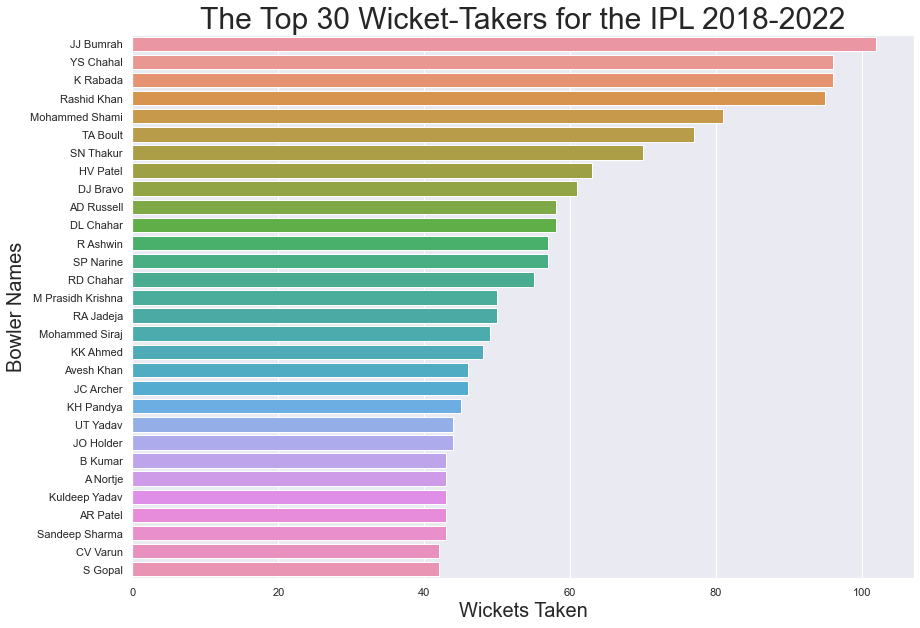

In [ ]:
keys = top_30_wkt.keys()
values = top_30_wkt.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 Wicket-Takers for the IPL 2018-2022",fontsize=30)
plt.xlabel('Wickets Taken',fontsize=20)
plt.ylabel('Bowler Names', fontsize=20)
plt.show()

Best Wicket-Taker : **JJ Bumrah**

From the above barplot we can see that Bumrah is the bowler who has taken the most number of wickets in the 5 years of IPL from 2018-2022. Thus our search for the best bowler is done right?? Not so fast. There are a variety of factors that has to be taken into consideration whilst picking the bowlers. One of them being the number of matches that they may have played. Now what we will do is carry out the above exercise 5 more times for 5 individual years and see how the results vary!

**Highest WicketTaker for each years between 2018-2022**

In [ ]:
wicket_18 = total_wickets(ball_2018df)
#Extracting the Top 30 Bowlers according to the number of wickets taken
top_30_wkt_18 = top_30_wick(wicket_18)
wicket_19 = total_wickets(ball_2019df)
#Extracting the Top 30 Bowlers according to the number of wickets taken
top_30_wkt_19 = top_30_wick(wicket_19)
wicket_20 = total_wickets(ball_2020df)
#Extracting the Top 30 Bowlers according to the number of wickets taken
top_30_wkt_20 = top_30_wick(wicket_20)
wicket_21 = total_wickets(ball_2021df)
#Extracting the Top 30 Bowlers according to the number of wickets taken
top_30_wkt_21 = top_30_wick(wicket_21)
wicket_22 = total_wickets(ball_2022df)
#Extracting the Top 30 Bowlers according to the number of wickets taken
top_30_wkt_22 = top_30_wick(wicket_22)


100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 521.01it/s]


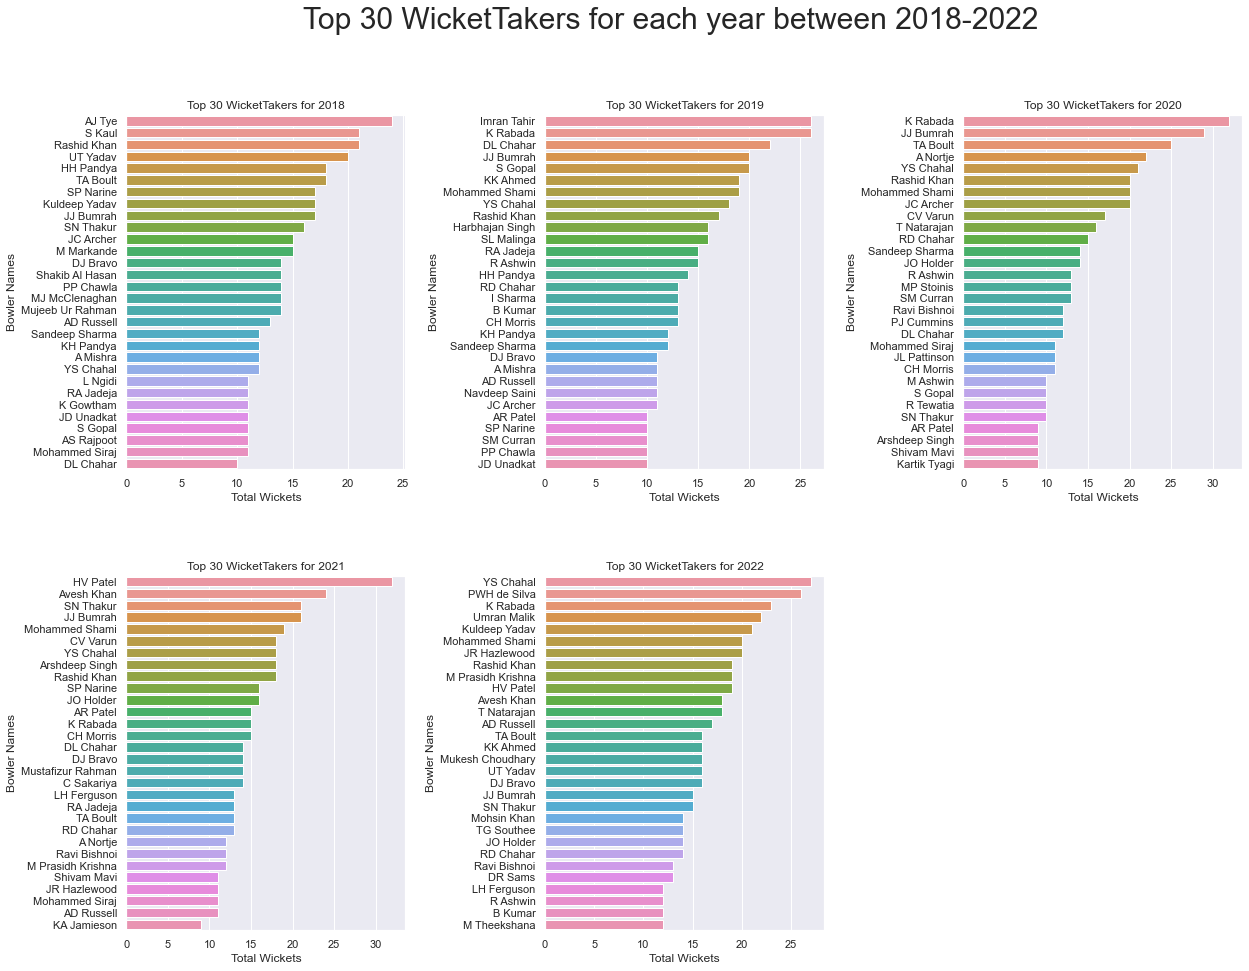

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.300, wspace=0.500)
fig.suptitle(' Top 30 WicketTakers for each year between 2018-2022', fontsize=30)


keys_18 = top_30_wkt_18.keys()
values_18 = top_30_wkt_18.values()
keys_19 = top_30_wkt_19.keys()
values_19 = top_30_wkt_19.values()
keys_20 = top_30_wkt_20.keys()
values_20 = top_30_wkt_20.values()
keys_21 = top_30_wkt_21.keys()
values_21 = top_30_wkt_21.values()
keys_22 = top_30_wkt_22.keys()
values_22 = top_30_wkt_22.values()

columns = 3
rows = 2
fig.add_subplot(rows, columns, 1)
ax1 = sns.barplot(y=list(keys_18), x=list(values_18))
ax1.set(xlabel="Total Wickets", ylabel="Bowler Names", title="Top 30 WicketTakers for 2018")
fig.add_subplot(rows, columns, 2)
ax2= sns.barplot(y=list(keys_19), x=list(values_19))
ax2.set(xlabel="Total Wickets", ylabel="Bowler Names",title="Top 30 WicketTakers for 2019")
fig.add_subplot(rows, columns, 3)
ax3 = sns.barplot(y=list(keys_20), x=list(values_20))
ax3.set(xlabel="Total Wickets", ylabel="Bowler Names",title="Top 30 WicketTakers for 2020")
fig.add_subplot(rows, columns, 4)
ax4 = sns.barplot(y=list(keys_21), x=list(values_21))
ax4.set(xlabel="Total Wickets", ylabel="Bowler Names",title="Top 30 WicketTakers for 2021")
fig.add_subplot(rows, columns, 5)
ax5 = sns.barplot(y=list(keys_22), x=list(values_22))
ax5.set(xlabel="Total Wickets", ylabel="Bowler Names",title="Top 30 WicketTakers for 2022")
    
plt.show()

####**Average Wickets Taken per over**

We can see above the Top 30 Wicket Takers for each year, the names do vary which is a given as each year the players that do participate keep on changing for various reasons.
Now the elephant in the room that we have to take into consideration is that there are players who may have recently just started playing in the IPL between 2021-2022 and therefore their wicket taking numbers may be lesser than the ones who have played so we go ahead and take WICKETS AVERAGE for the player, i.e regardless of how many seasons he plays, we take the average number of wickets he has taken per match.
We also have to keep in mind that for a player to be categorized as a primary bowler, he has to ball a minimum of 3 overs in each match he has played, otherwise a player can play only 1  match, get 2-3 wickets and have an average of 3 which is misleading as that would mean that he is a great bowler even though he may not be!!! So we set a threshold of number of matches X 3 to be the minimum overs to be bowled by the baller to be considered a baller

In [ ]:
#Average Wicket Count Function
def avg_wickets(df):
    wicketcount = {}
    #List of all the bowlers from 2018-2022 who have bowled 
    bowlers = list(df.bowler.unique())
    #Going through all the bowlers
    for bowler in tqdm(bowlers):
        #Creating the dataframe only for that bowler
        bowl_df = df.loc[df["bowler"]==bowler]
        matches = len(bowl_df.ID.unique())
        total_overs = bowl_df.drop_duplicates(subset=['ID','overs'], keep="last").shape[0]
        threshold = matches * 3
        #Finding the outcome of all the balls that he has balled
        if threshold <=total_overs:
            wickets = bowl_df.kind.value_counts()
            count = 0
            #Finding the number of wickets taken
            for wicket in wicket_type:
                if wicket in list(wickets.keys()):
                    count+=wickets[wicket]
            wicketcount[bowler]=count/matches
    return wicketcount

In [ ]:
#Average WicketTaker Top 30 Bowlers
avg_wkt_dict = avg_wickets(full_balldf)
top_30_aw = top_30_wick(avg_wkt_dict)

100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:01<00:00, 144.35it/s]


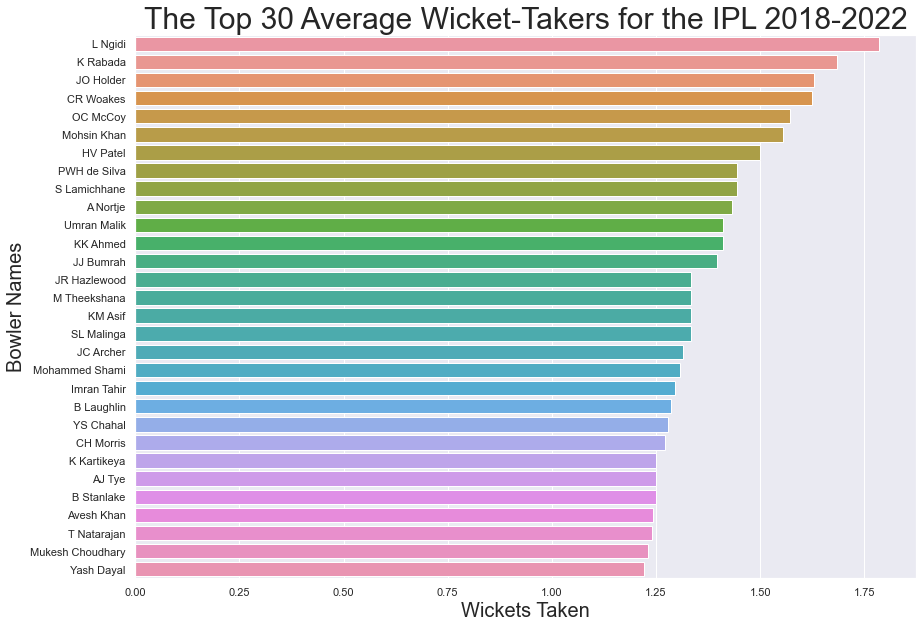

In [ ]:
keys = top_30_aw.keys()
values = top_30_aw.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 Average Wicket-Takers for the IPL 2018-2022",fontsize=30)
plt.xlabel('Wickets Taken',fontsize=20)
plt.ylabel('Bowler Names', fontsize=20)
plt.show()

Best Average Wicket Taker: **L NGIDI**

Using our new Statistical Metric Measure we see that the graph has changed and there is a new Top Wicket Taker. We use similar assumptions and inferences to go ahead with further statistics from now

####**Economy Rate**

Let's now check for the bowlers who have conceded the least number of runs.

But the fact is that it's not so straightforward, because there may be some players who may have bowled only one over throughout the year and has conceded only 6 runs which would mean that they would be a great player which is quite misleading!!! So we bring in the concept of .... ECONOMY!!!!

Economy is nothing but the average amount of runs that may be conceded by the player for one over so that would remove the bias of what was stated above, and that's what we will do now!

We also have to take into consideration the number of overs balled so therefore we take a particular threshold value to do that. We know that number of matches played is 14 for each season discarding the finals etc. We take the sam approach of taking a minimum of 3 overs balled by a bowler if he has played the match and therefore have went ahead with our analysis

In [ ]:
#Economy Calculator Function for individual 5 years
def economy_calc(df):
    economy = {}
    #List of all the bowlers from 2018-2022 who have bowled
    bowlers = list(df.bowler.unique())
    for bowler in tqdm(bowlers):
        bowl_df = df.loc[df["bowler"]==bowler]
        matches = len(bowl_df.ID.unique())
        total_overs = bowl_df.drop_duplicates(subset=['ID','overs'], keep="last").shape[0]
        threshold = matches * 3
        if total_overs >= threshold:
            total_runs = bowl_df.total_run.sum()
            economy[bowler] = round(total_runs/total_overs,4)
    return economy

In [ ]:
economy_all = economy_calc(full_balldf)
top_30_economy = top_30_eco(economy_all)

100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:01<00:00, 159.87it/s]


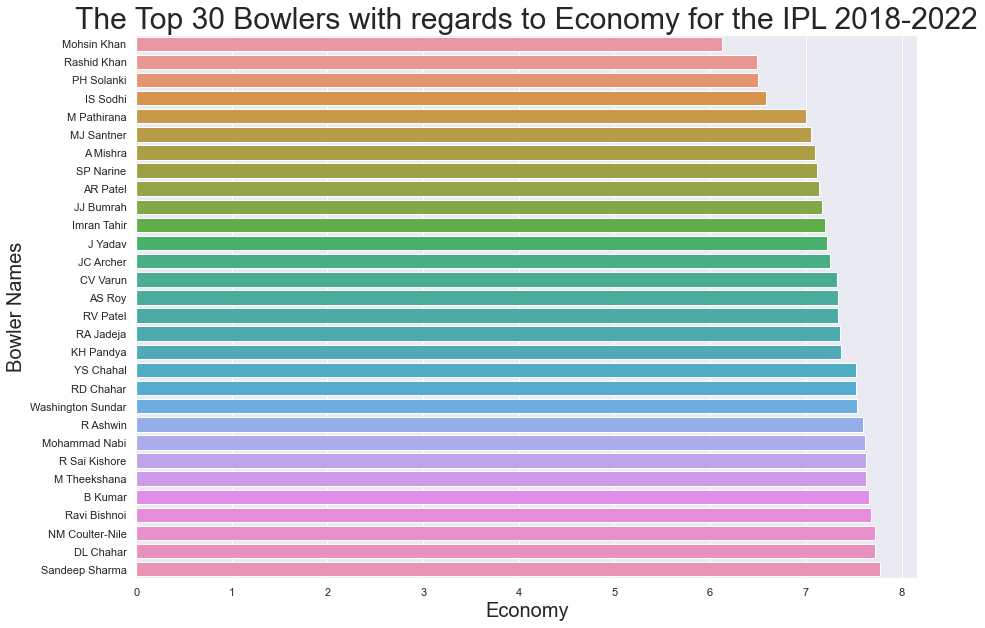

In [ ]:
keys = top_30_economy.keys()
values = top_30_economy.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 Bowlers with regards to Economy for the IPL 2018-2022",fontsize=30)
plt.xlabel('Economy',fontsize=20)
plt.ylabel('Bowler Names', fontsize=20)
plt.show()

In [ ]:
economy_18 = economy_calc(ball_2018df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_economy_18 = top_30_eco(economy_18)
economy_19 = economy_calc(ball_2019df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_economy_19 = top_30_eco(economy_19)
economy_20 = economy_calc(ball_2020df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_economy_20 = top_30_eco(economy_20)
economy_21 = economy_calc(ball_2021df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_economy_21 = top_30_eco(economy_21)
economy_22 = economy_calc(ball_2022df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_economy_22 = top_30_eco(economy_22)

100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 362.29it/s]


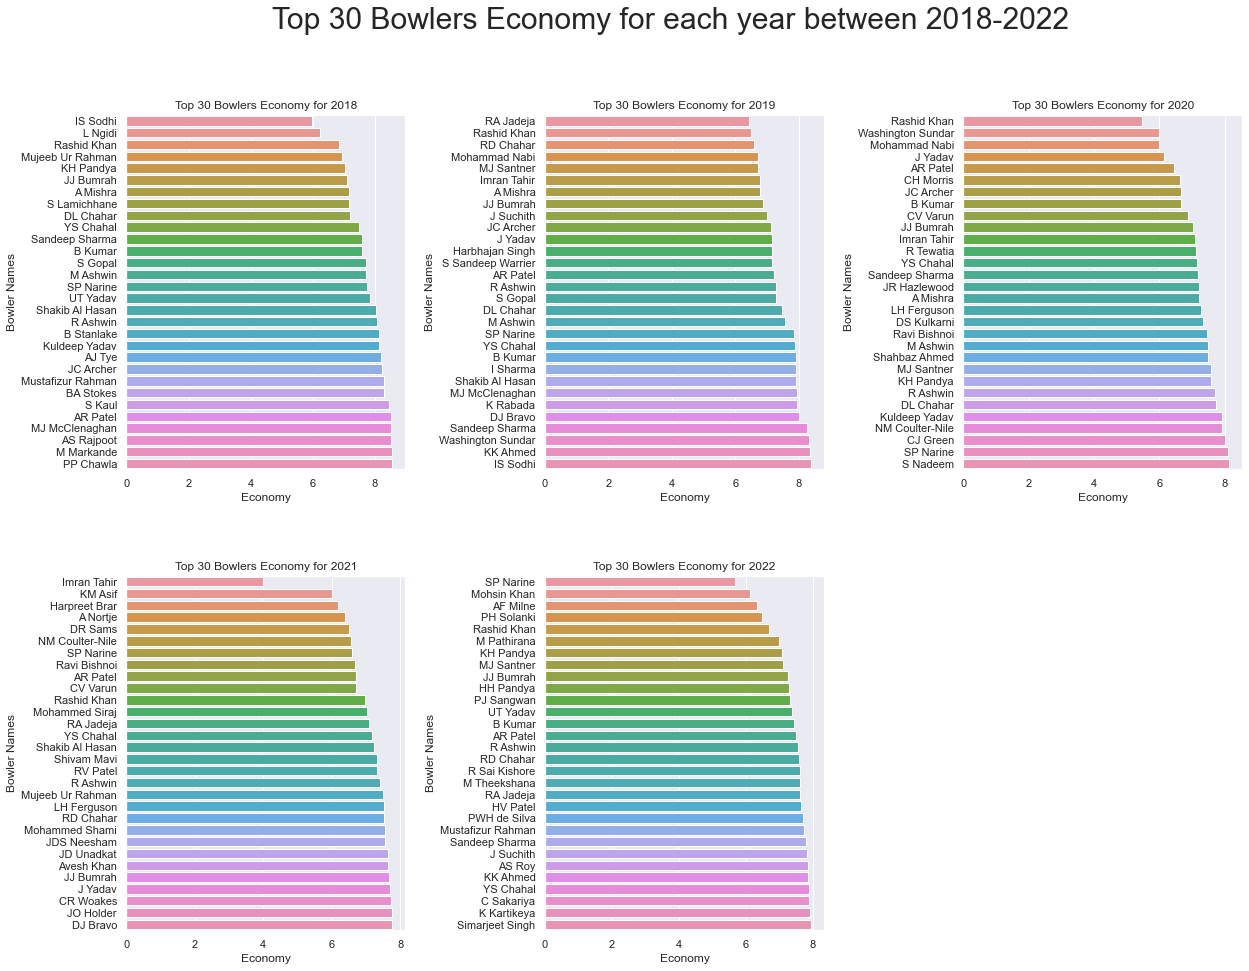

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.300, wspace=0.500)
fig.suptitle(' Top 30 Bowlers Economy for each year between 2018-2022', fontsize=30)


keys_18 = top_30_economy_18.keys()
values_18 = top_30_economy_18.values()
keys_19 = top_30_economy_19.keys()
values_19 = top_30_economy_19.values()
keys_20 = top_30_economy_20.keys()
values_20 = top_30_economy_20.values()
keys_21 = top_30_economy_21.keys()
values_21 = top_30_economy_21.values()
keys_22 = top_30_economy_22.keys()
values_22 = top_30_economy_22.values()

columns = 3
rows = 2
fig.add_subplot(rows, columns, 1)
ax1 = sns.barplot(y=list(keys_18), x=list(values_18))
ax1.set(xlabel="Economy", ylabel="Bowler Names", title="Top 30 Bowlers Economy for 2018")
fig.add_subplot(rows, columns, 2)
ax2= sns.barplot(y=list(keys_19), x=list(values_19))
ax2.set(xlabel="Economy", ylabel="Bowler Names",title="Top 30 Bowlers Economy for 2019")
fig.add_subplot(rows, columns, 3)
ax3 = sns.barplot(y=list(keys_20), x=list(values_20))
ax3.set(xlabel="Economy", ylabel="Bowler Names",title="Top 30 Bowlers Economy for 2020")
fig.add_subplot(rows, columns, 4)
ax4 = sns.barplot(y=list(keys_21), x=list(values_21))
ax4.set(xlabel="Economy", ylabel="Bowler Names",title="Top 30 Bowlers Economy for 2021")
fig.add_subplot(rows, columns, 5)
ax5 = sns.barplot(y=list(keys_22), x=list(values_22))
ax5.set(xlabel="Economy", ylabel="Bowler Names",title="Top 30 Bowlers Economy for 2022")
    
plt.show()

Analysing the data for 5 years, we see **Rashid Khan** as a perfect bowler with consistency at economy rate. Hence he has become our choice.

####**Bowling Average**


Bowling Average is a term to measure how many runs, a bowler gives for every wicket he takes. So the lower the Bowling Average, the greater is the Bowler to be considered.
Bowling Average = Total Runs/Total Wickets Taken. A number of flaws have been identified for the statistic, most notable among these the fact that a bowler who has taken no wickets cannot have a bowling average, as dividing by zero does not give a result thus we take this into consideration and not take the players who have not taken a wicket at all
We take the same approach as we have taken above, take all 5 years and then the individuals years

In [ ]:
#Bowling Average Calculator Function
def bowl_avg_calc(df):
    bowl_avg = {}
    #List of all the bowlers from 2018-2022 who have bowled
    bowlers = list(df.bowler.unique())
    for bowler in tqdm(bowlers):
        bowl_df = df.loc[df["bowler"]==bowler]
        #Finding the outcome of all the balls that he has balled
        wickets = bowl_df.kind.value_counts()
        count = 0
        matches = len(bowl_df.ID.unique())
        total_overs = bowl_df.drop_duplicates(subset=['ID','overs'], keep="last").shape[0]
        threshold = matches * 3
        if total_overs >= threshold:
            #Finding the number of wickets taken
            for wicket in wicket_type:
                if wicket in list(wickets.keys()):
                    count+=wickets[wicket]
            if (count != 0):
                total_runs = bowl_df.total_run.sum()
                bowl_avg[bowler] = round(total_runs/count,4)
    return bowl_avg

In [ ]:
average_all = bowl_avg_calc(full_balldf)
top_30_average = top_30_avg(average_all)

100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:01<00:00, 152.87it/s]


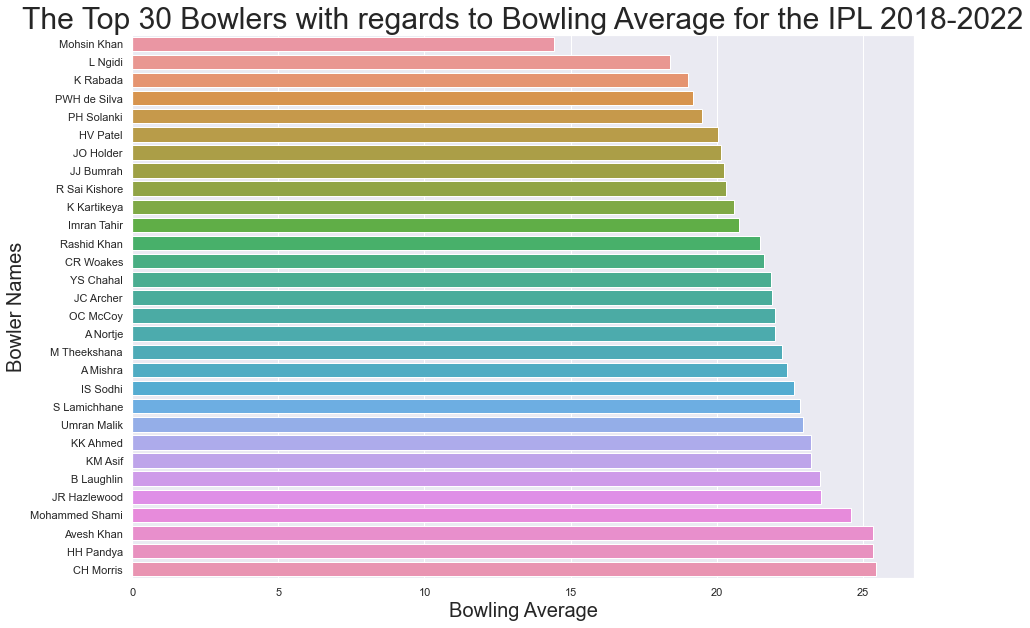

In [ ]:
keys = top_30_average.keys()
values = top_30_average.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 Bowlers with regards to Bowling Average for the IPL 2018-2022",fontsize=30)
plt.xlabel('Bowling Average',fontsize=20)
plt.ylabel('Bowler Names', fontsize=20)
plt.show()

Best Bowler with regards to Bowling Average: Mohsin Khan

But as Mohsin Khan is still an uncapped player, he cant be considered in the World XI.


In [ ]:
avg_18 = bowl_avg_calc(ball_2018df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_avg_18 = top_30_avg(avg_18)
avg_19 = bowl_avg_calc(ball_2019df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_avg_19 = top_30_avg(avg_19)
avg_20 = bowl_avg_calc(ball_2020df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_avg_20 = top_30_avg(avg_20)
avg_21 = bowl_avg_calc(ball_2021df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_avg_21 = top_30_avg(avg_21)
avg_22 = bowl_avg_calc(ball_2022df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_avg_22 = top_30_avg(avg_22)

100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 305.18it/s]


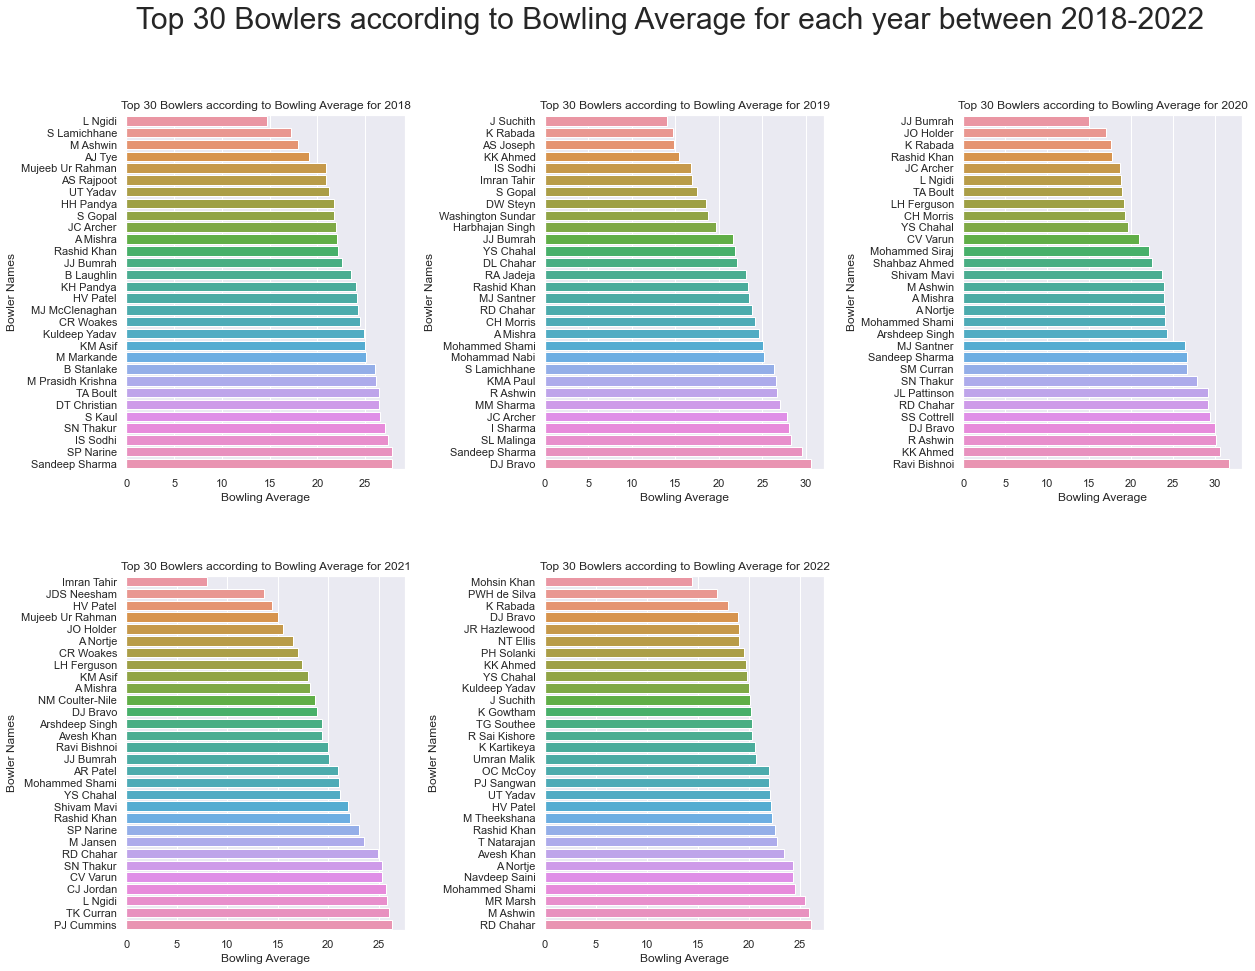

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.300, wspace=0.500)
fig.suptitle(' Top 30 Bowlers according to Bowling Average for each year between 2018-2022', fontsize=30)


keys_18 = top_30_avg_18.keys()
values_18 = top_30_avg_18.values()
keys_19 = top_30_avg_19.keys()
values_19 = top_30_avg_19.values()
keys_20 = top_30_avg_20.keys()
values_20 = top_30_avg_20.values()
keys_21 = top_30_avg_21.keys()
values_21 = top_30_avg_21.values()
keys_22 = top_30_avg_22.keys()
values_22 = top_30_avg_22.values()

columns = 3
rows = 2
fig.add_subplot(rows, columns, 1)
ax1 = sns.barplot(y=list(keys_18), x=list(values_18))
ax1.set(xlabel="Bowling Average", ylabel="Bowler Names", title="Top 30 Bowlers according to Bowling Average for 2018")
fig.add_subplot(rows, columns, 2)
ax2= sns.barplot(y=list(keys_19), x=list(values_19))
ax2.set(xlabel="Bowling Average", ylabel="Bowler Names",title="Top 30 Bowlers according to Bowling Average for 2019")
fig.add_subplot(rows, columns, 3)
ax3 = sns.barplot(y=list(keys_20), x=list(values_20))
ax3.set(xlabel="Bowling Average", ylabel="Bowler Names",title="Top 30 Bowlers according to Bowling Average for 2020")
fig.add_subplot(rows, columns, 4)
ax4 = sns.barplot(y=list(keys_21), x=list(values_21))
ax4.set(xlabel="Bowling Average", ylabel="Bowler Names",title="Top 30 Bowlers according to Bowling Average for 2021")
fig.add_subplot(rows, columns, 5)
ax5 = sns.barplot(y=list(keys_22), x=list(values_22))
ax5.set(xlabel="Bowling Average", ylabel="Bowler Names",title="Top 30 Bowlers according to Bowling Average for 2022")
    
plt.show()

####**Bowling Strike-Rate**


Bowling Strike-rate is a measure to find how frequently a bowler picks a wicket. That is, how many balls the bowler required to pick the total wickets he has taken?
Bowling Strike-Rate = Balls Bowled/Total Wickets Taken. A number of flaws have been identified for the statistic, most notable among these the fact that a bowler who has taken no wickets cannot have a bowling strike-rate, as dividing by zero does not give a result thus we take this into consideration and not take the players who have not taken a wicket at all. We take a minimumum of 6000 balls bowled to consider the bowler into consideration
We take the same approach as we have taken above, take all 5 years and then the individuals years

In [ ]:
#Bowling Strike-Rate Calculator Function for all 5 years
def bowl_sr_calc(df):
    bowl_sr = {}
    #List of all the bowlers from 2018-2022 who have bowled
    bowlers = list(df.bowler.unique())
    for bowler in tqdm(bowlers):
        bowl_df = df.loc[df["bowler"]==bowler]
        #Finding the outcome of all the balls that he has balled
        wickets = bowl_df.kind.value_counts()
        count = 0
        matches = len(bowl_df.ID.unique())
        total_balls = bowl_df.shape[0]
        threshold = matches * 3 * 6
        if total_balls >= threshold:
            #Finding the number of wickets taken
            for wicket in wicket_type:
                if wicket in list(wickets.keys()):
                    count+=wickets[wicket]
            if (count != 0):
                bowl_sr[bowler] = round(total_balls/count,4)
    return bowl_sr

In [ ]:
sr_all = bowl_sr_calc(full_balldf)
top_30_strikerate = top_30_sr(sr_all)

100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:01<00:00, 196.27it/s]


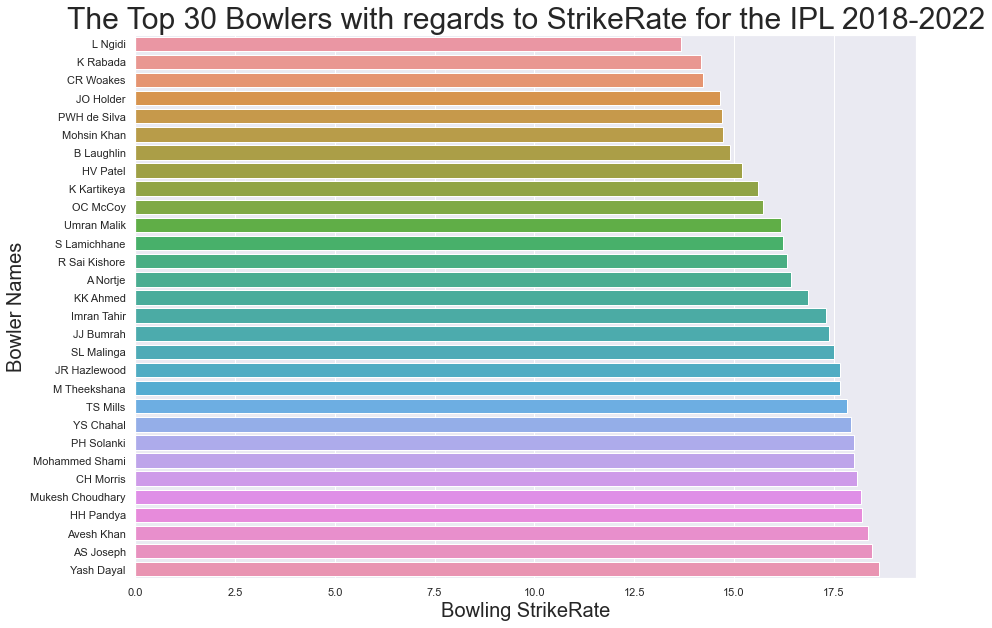

In [ ]:
keys = top_30_strikerate.keys()
values = top_30_strikerate.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 Bowlers with regards to StrikeRate for the IPL 2018-2022",fontsize=30)
plt.xlabel('Bowling StrikeRate',fontsize=20)
plt.ylabel('Bowler Names', fontsize=20)
plt.show()

Best Bowler with regards to Bowling Strike Rate: **L Ngidi**

In [ ]:
sr_18 = bowl_sr_calc(ball_2018df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_sr_18 = top_30_sr(sr_18)
sr_19 = bowl_sr_calc(ball_2019df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_sr_19 = top_30_sr(sr_19)
sr_20 = bowl_sr_calc(ball_2020df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_sr_20 = top_30_sr(sr_20)
sr_21 = bowl_sr_calc(ball_2021df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_sr_21 = top_30_sr(sr_21)
sr_22 = bowl_sr_calc(ball_2022df)
#Extracting the Top 30 Bowlers according to the economy taken
top_30_sr_22 = top_30_sr(sr_22)

100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 503.05it/s]


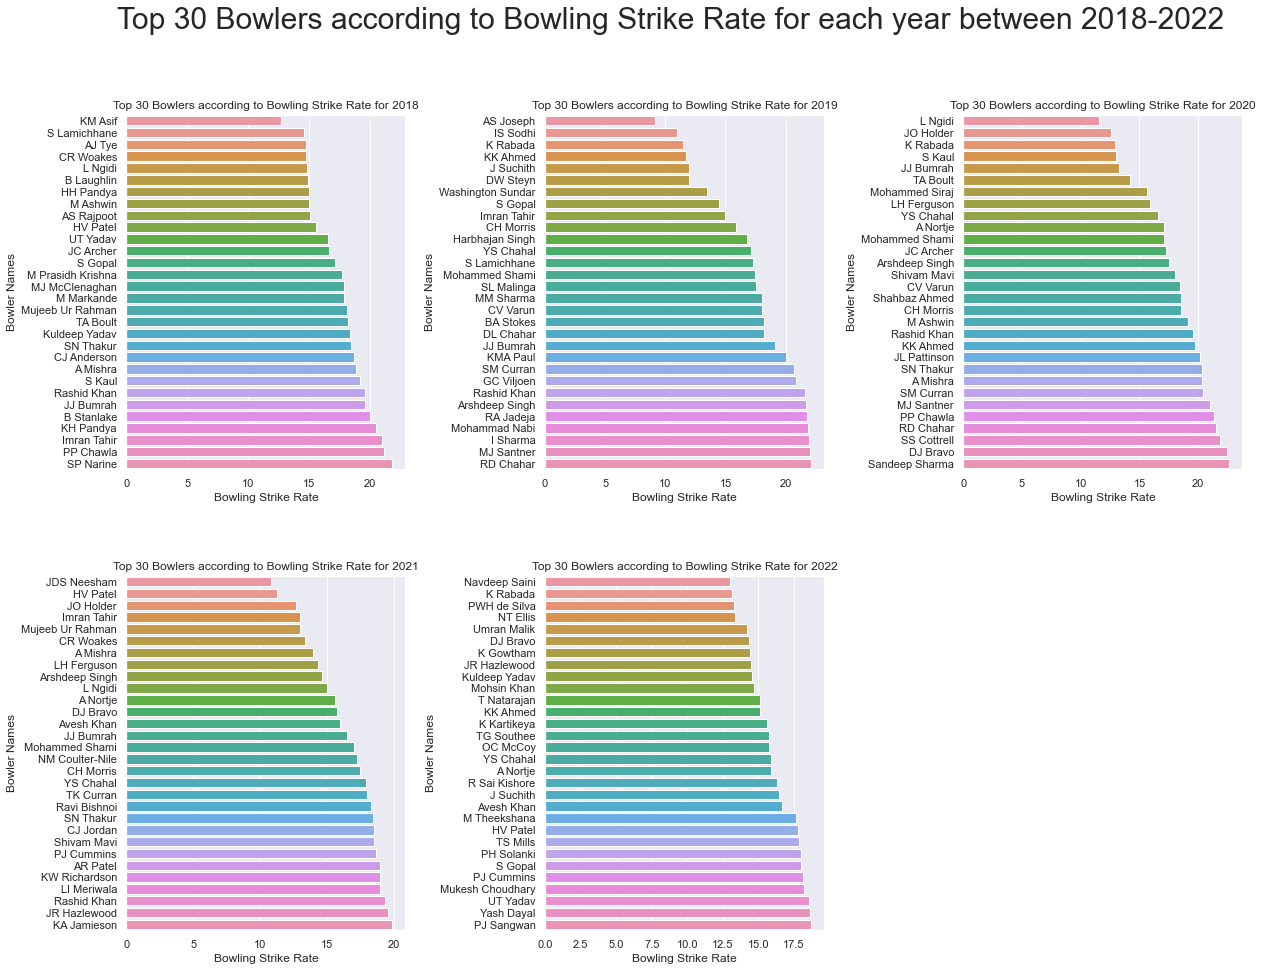

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.300, wspace=0.500)
fig.suptitle(' Top 30 Bowlers according to Bowling Strike Rate for each year between 2018-2022', fontsize=30)


keys_18 = top_30_sr_18.keys()
values_18 = top_30_sr_18.values()
keys_19 = top_30_sr_19.keys()
values_19 = top_30_sr_19.values()
keys_20 = top_30_sr_20.keys()
values_20 = top_30_sr_20.values()
keys_21 = top_30_sr_21.keys()
values_21 = top_30_sr_21.values()
keys_22 = top_30_sr_22.keys()
values_22 = top_30_sr_22.values()

columns = 3
rows = 2
fig.add_subplot(rows, columns, 1)
ax1 = sns.barplot(y=list(keys_18), x=list(values_18))
ax1.set(xlabel="Bowling Strike Rate", ylabel="Bowler Names", title="Top 30 Bowlers according to Bowling Strike Rate for 2018")
fig.add_subplot(rows, columns, 2)
ax2= sns.barplot(y=list(keys_19), x=list(values_19))
ax2.set(xlabel="Bowling Strike Rate", ylabel="Bowler Names",title="Top 30 Bowlers according to Bowling Strike Rate for 2019")
fig.add_subplot(rows, columns, 3)
ax3 = sns.barplot(y=list(keys_20), x=list(values_20))
ax3.set(xlabel="Bowling Strike Rate", ylabel="Bowler Names",title="Top 30 Bowlers according to Bowling Strike Rate for 2020")
fig.add_subplot(rows, columns, 4)
ax4 = sns.barplot(y=list(keys_21), x=list(values_21))
ax4.set(xlabel="Bowling Strike Rate", ylabel="Bowler Names",title="Top 30 Bowlers according to Bowling Strike Rate for 2021")
fig.add_subplot(rows, columns, 5)
ax5 = sns.barplot(y=list(keys_22), x=list(values_22))
ax5.set(xlabel="Bowling Strike Rate", ylabel="Bowler Names",title="Top 30 Bowlers according to Bowling Strike Rate for 2022")
    
plt.show()

####**Death Over Bowlers**

Now that we have looked over the 5 Statistics that are the most saught after for a bowler, we will now break down our analysis to Death Overs and PowerPlay Overs. We will now select a player from each of these categories and thus complete our analysis of the best bowlers


**What is a death over?**
The death overs are the last few overs of an innings in the shorter formats of cricket. In T20 matches, the last 4/5 overs are commonly referred to as death overs. In 50 over matches, the last 10 overs are usually said to be the death overs. In these overs batting teams will be trying to score runs quicker than normal.
We thus want to find the bowlers who have the best economy rate during these overs as the bowlers' main aim is to stop as much runs as possible to be scored by the batsman. So we now use a dataframe which has been extracted earlier with regards to death overs and find the bowler who is worth to be named "The Death Over King". Let's Go!

In [ ]:
#Economy Calculator Function for individual 5 years
def death_economy_calc(df):
    economy = {}
    #List of all the bowlers from 2018-2022 who have bowled
    bowlers = list(df.bowler.unique())
    for bowler in tqdm(bowlers):
        bowl_df = df.loc[df["bowler"]==bowler]
        matches = len(bowl_df.ID.unique())
        death_df = bowl_df.loc[bowl_df["overs"]>=16]
        death_overs_total = death_df.drop_duplicates(subset=["ID","overs"]).shape[0]
        if death_overs_total > matches & matches>=9 :
            total_runs = death_df.total_run.sum()
            economy[bowler] = round(total_runs/death_overs_total,4)
    return economy

In [ ]:
death_economy = death_economy_calc(full_balldf)
top_30_de = top_30_eco(death_economy)

100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:01<00:00, 199.37it/s]


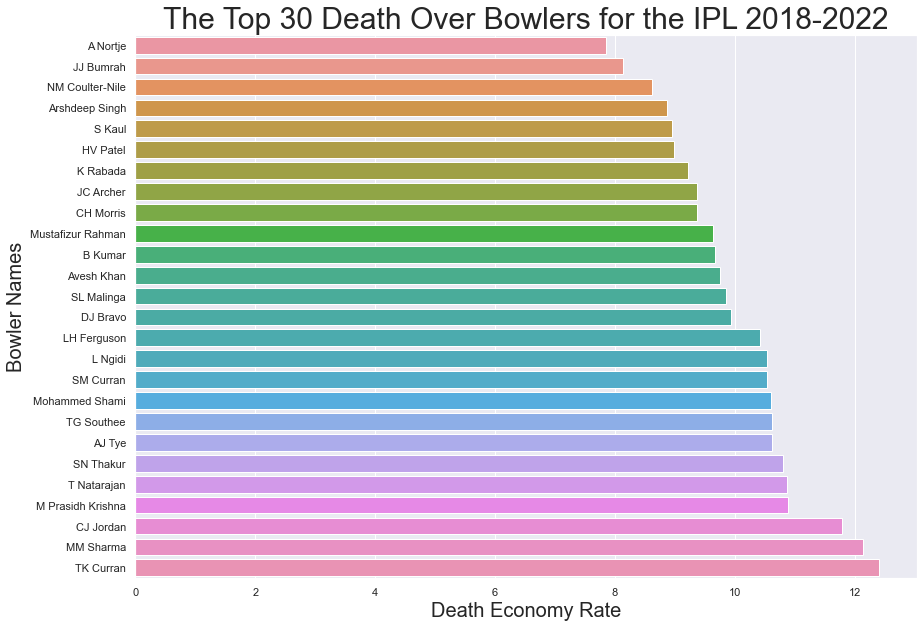

In [ ]:
keys = top_30_de.keys()
values = top_30_de.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 Death Over Bowlers for the IPL 2018-2022",fontsize=30)
plt.xlabel('Death Economy Rate',fontsize=20)
plt.ylabel('Bowler Names', fontsize=20)
plt.show()

Best Death Bowler: **A Nortje**

In [ ]:
power_economy = power_wicket_calc_dem(full_balldf)
top_30_pe = top_30_wick(power_economy)

100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:01<00:00, 192.08it/s]


####**PowerPlay Bowlers**


**What is a Powerplay?**

The Powerplay is the term given to a set of overs with special fielding rules during a limited overs cricket match. During a powerplay, only 2 fielders are allowed outside the 30-yard circle for the first 10 overs in an ODI match and first 6 overs of a T20 match. There are no powerplay rules in a Test Match.

Powerplay takes place at the start of the match and therefore is the part of of the match which sets the narrative for a match. Thus bowlers have the responsibility to take wickets as it's the time when the batsmen have not settled and therefore are the most vulnerable.  Let's find out 

In [ ]:
#Economy Calculator Function for individual 5 years
def power_wicket_calc_dem(df):
    wicket_taken = {}
    #List of all the bowlers from 2018-2022 who have bowled
    bowlers = list(df.bowler.unique())
    for bowler in tqdm(bowlers):
        bowl_df = df.loc[df["bowler"]==bowler]
        matches = len(bowl_df.ID.unique())
        power_df = bowl_df.loc[bowl_df["overs"]<=6]
        total_runs = power_df.total_run.sum()
        wickets = power_df.kind.value_counts()
        power_overs_total = power_df.drop_duplicates(subset=["ID","overs"]).shape[0]
        count = 0
        if power_overs_total > matches & matches>=9 :
            for wicket in wicket_type:
                if wicket in list(wickets.keys()):
                    count+=wickets[wicket]
            wicket_taken[bowler] = count
    return wicket_taken

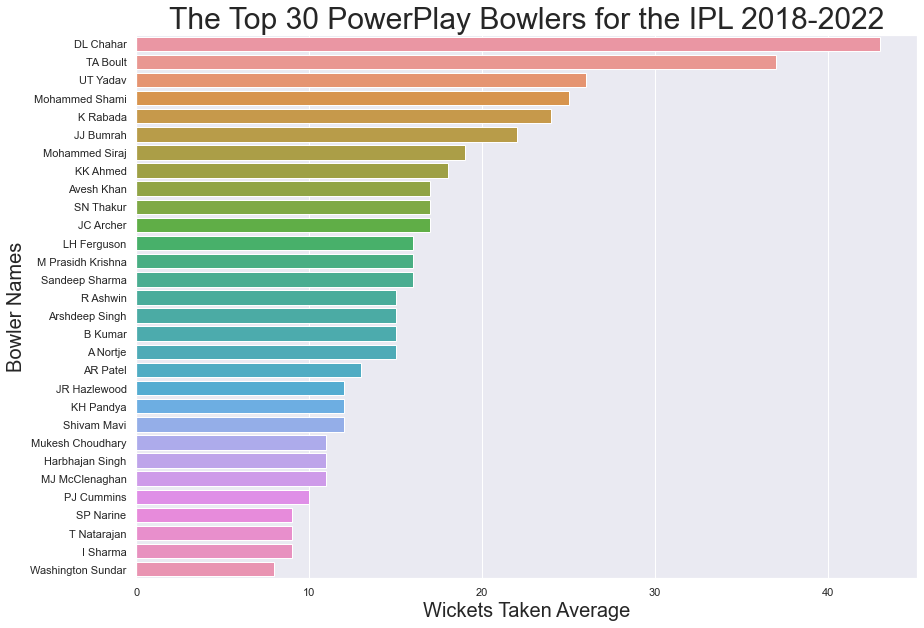

In [ ]:
keys = top_30_pe.keys()
values = top_30_pe.values()
# Set the figure size
plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(y=list(keys), x=list(values));
plt.title("The Top 30 PowerPlay Bowlers for the IPL 2018-2022",fontsize=30)
plt.xlabel('Wickets Taken Average',fontsize=20)
plt.ylabel('Bowler Names', fontsize=20)
plt.show()

Best PowerPlay Bowler: **Deepak Chahar**

###Bowlers Team Selection
7. **Rashid Khan**
8. **L Ngid**i
9. **DL Chahar**
10. **A Nortje**
11. **JJ Bumrah**

##**World XI**
1. **DA Warner**
2. **JC Buttler**
3. **V Kohli**
4. **KL Rahul**
5. **DA Miller**
6. **AD Russel**
7. **Rashid Khan**
8. **L Ngidi**
9. **DL Chahar**
10. **A Nortje**
11. **JJ Bumrah**

##**Conclusion**

Utilizing the power of data exploration and analysis we were able to find out various interesting insights about cricket. 
We were able to understand the importance of Toss and how it provides an edge to most of the international teams. 
Utilizing IPL Dataset we were able to identify the great players of the game. 
We were able to understand that various metrics to be considered to find out the best of players.

The project has helped us significantly in mastering our skills in Scrapping data from the internet source, creating pipeline for data analysis, exploratory data analysis, Data visualization and deriving intuition based decisions from the statistical analysis of the data.

The project was also a refresher on our concepts in using pandas, seaborn and matplotlib to a greater extent. Data cleaning, and preprocessing indeed was a great task in this project.

*Few challenges we faced were*-

Getting the nationality of the players, which even though was available in a seperate dataframe, still the names in both the dataframes were not in the same manner (eg: JJ Bumrah and Jasprit B for the same person). This made the string match difficult. 

Also there were instances where bowlers came up in the analysis of top strikers, which is due to the less number of balls the bowlers face and their hard hitting nature which might not be possible for a good batsmen. So to avoid such outliers, we had to use different masks. We to a great extent solve this problem. Still our project is not completely out of this error. This could be a major improvement we could bring about in our project.

Most bowlers were fast pacers and not spinners, this was due to the lack of role column in the dataset, we can correct this by finding out more details  about the players by scraping various cricket websites to gain the required information


Also there happened to be palyed only one or two easons of IPL or players who were retired from International Cricket but active in Domestic League crickets. So we were not able to filter such players due to lack of available data on them. Web scrapping all the player information from internet and then finding their retirement can be a solution, but a tedious task, beyond the scope of this project. This is where we had to use our intuition and select players based on our intuition.


Apart from all these challenges, this project was a great learning experience for our beginning as Data Scientists!
